# Magnotether Loop LED 

Analysis of a a continuous rotating stimulus on fruit fly behavior

In [347]:
# relevant packages
import sys
import os
import os.path
import cv2
import numpy as np
import matplotlib.pyplot as plt

## the find fly angle was initially developed by the Dickson Lab at Caltech but is undergoing refinement by the Warren Lab
from find_fly_angle.find_fly_anglev2 import *


> For using this jupyter notebook a lot of the analysis considers images located on an external machine (unless you are currently using that machine). This notebook thus has data import methods for both external access and direct access of the image files.

For the external access ensure that the following is completed... However, the majority of analysis images that will be analyzed will be included within this repo. The inital formulation of these images and getting more images saved directly will require the external access which is why it is recommended that the following steps are followed:

1. Set mount point in home directory
```
mkdir magno_mount
```

2. Using SSHFS set the mount
```
sshfs flyranch@IPADDRESS: /home/username/magno_mount/
```

3. Connection has been established now you can navigate to the proper directory

This will be done later within this notebook as well for the access of the images, but if you are wanting to look at some of these 
images on your own machine within the mount point this is the directory that will be used
```
cd image_data/20231121/fly1/20231121124749/
```

With the relevant dependancies and connections established, proceed through the rest of the notebook.



## Fuctions for visualization creation and saving

# ISSUE IS STILL WITH THE ANGLE!

In [348]:
def get_objectmask(maskFly,max_contour):
    """
    function that converts the mask of the fly and image to just the
    mask of the fly on a background
    """
    # get the mask of fly that is same size but zeros
    gen_mask = np.zeros(maskFly.shape,dtype='uint8')
    # convert image to BGR
    img_fly_mask_cont = cv2.cvtColor(gen_mask,cv2.COLOR_GRAY2BGR)
    # draw the contours on this mask
    cv2.drawContours(img_fly_mask_cont,[max_contour],contourIdx =0, color = (255,255,255),thickness = 4)
    return img_fly_mask_cont

def get_fill_flymask(maskFly, max_contour):
    """
    show the mask fly with contour areay filled in
    """
    # get fly with contour on background
    cont_mask = get_objectmask(maskFly,max_contour)
    # convert back to grayscale
    cont_mask = cv2.cvtColor(cont_mask,cv2.COLOR_BGR2GRAY)
    # fill in the fly contour to get the mask
    cv2.fillPoly(cont_mask,[max_contour],color = (255))
    return cont_mask

## single image
def single_image_save(file_name,display=False):
    """
    single image save function that takes known file name.
    the user can additionally allow for the images to be displayed within the notebook

    Some of the code within this function is taken from the find_fly_angle module
    """
    # read in the image file of the fly as Grayscale
    img_fly = cv2.imread(file_name,cv2.IMREAD_GRAYSCALE)
    # Get basic image data
    height, width = img_fly.shape
    print("height",height)
    image_cvsize = width, height 
    mid_x, mid_y = 0.5*width, 0.5*height
    # perform otsu thresholding
    otsu_th, img_otsu = cv2.threshold(img_fly,0,256,cv2.THRESH_OTSU +cv2.THRESH_BINARY_INV)

    # (Optional) -> Morphology: erosion
    strel = np.ones((5,5),np.uint8)  

    # maskFly = cv2.dilate(img_otsu, strel)
    # perform an erosing
    fly_mask = cv2.morphologyEx( cv2.morphologyEx(img_otsu, cv2.MORPH_CLOSE, strel), cv2.MORPH_OPEN, strel)


    # get the contours
    contours,hierarchy = cv2.findContours(fly_mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    # utilize find_fly_angle function to get max area and contour
    max_contour, max_area = get_max_area_contour(contours)
    # determine the centroid using find_fly_angle function
    Cx, Cy = get_centroid(cv2.moments(max_contour))# centroid x,y coordinates
    ## centroid
    centroid = (int(Cx), int(Cy))
    # determine the angle and body vectory using finde_fly_angle function
    angle, body_vect = get_angle_and_body_vector(cv2.moments(max_contour))
    # Get bounding box and find diagonal - used for drawing body axis
    bbox = cv2.boundingRect(max_contour)
    bbox_diag = np.sqrt(bbox[2]**2 + bbox[3]**2)
    # Create points for drawing axis fly in contours image 
    axis_length = 0.75*bbox_diag
    body_axis_pt_0 = int(Cx+ axis_length*body_vect[0]), int(Cy+ axis_length*body_vect[1])
    body_axis_pt_1 = int(Cx- axis_length*body_vect[0]), int(Cy - axis_length*body_vect[1])

    # Compute cirlce mask
    mask_radius = int(.95*height/2.0)
    print('mask radius',mask_radius)
    vals_x = np.arange(0.0,width)
    vals_y = np.arange(0.0,height)
    grid_x, grid_y = np.meshgrid(vals_x, vals_y)    ## plot the centroid
    # plt.plot(centroid[0],centroid[1],marker = '.',color = 'r' ,markersize= 10)

    ## plot arrow of direction
    endpoint_x = centroid[0] + axis_length*body_vect[0]
    endpoint_y = centroid[1] - axis_length*body_vect[1]
    # plt.arrow(body_axis_pt_0[0],body_axis_pt_0[1],body_axis_pt_1[0],body_axis_pt_1[1],
    #             width=1,  # Width of the arrow
    #             head_width=30,  # Width of the arrow head
    #             head_length=35,  # Length of the arrow head
    #             fc='blue',  # Fill color of the arrow
    #             ec='blue',  # Edge color of the arrow
    #             linestyle='-',  # Style of the arrow
    #             length_includes_head=True

    #             )
    # cv2.line(img_fly, body_axis_pt_0, body_axis_pt_1, (0,0,255), 2)

    # ##  plot the image
    # plt.imshow(img_fly,cmap ='gray')
    
    circ_mask = (grid_x - width/2.0 + 0.5)**2 + (grid_y - height/2.0 + 0.5)**2 < (mask_radius)**2



    # Get matrices for shifting (centering) and rotating the image
    shift_mat = np.matrix([[1.0, 0.0, (mid_x - Cx)], [0.0, 1.0, (mid_y - Cy)]]) 
    rot_mat = cv2.getRotationMatrix2D((mid_x, mid_y),np.rad2deg(angle),1.0)

    # Shift and rotate the original image
    shifted_image = cv2.warpAffine(img_fly, shift_mat, image_cvsize)
    rotated_image = cv2.warpAffine(shifted_image,rot_mat,image_cvsize)

    # Shift and rotate threshold image. 
    shifted_threshold_image = cv2.warpAffine(fly_mask, shift_mat, image_cvsize)
    rotated_threshold_image = cv2.warpAffine(shifted_threshold_image,rot_mat,image_cvsize)
    rotated_threshold_image = rotated_threshold_image*circ_mask
    rval, rotated_threshold_image  = cv2.threshold(rotated_threshold_image,0,256,cv2.THRESH_OTSU +cv2.THRESH_BINARY_INV)
    # Get orientation discriminant and flip image if needed 
    orient_ok, orient_discrim = is_orientation_ok(rotated_threshold_image,2)
    if not orient_ok:
        rot_180_mat = cv2.getRotationMatrix2D((mid_x, mid_y),-180.0,1.0)
        rotated_image = cv2.warpAffine(rotated_image,rot_180_mat,image_cvsize)
        rotated_threhold_image = cv2.warpAffine(rotated_threshold_image,rot_180_mat,image_cvsize)
        angle += np.deg2rad(-180.0)

    # angle = normalize_angle_range(angle)
    print("angle final", angle)
    # The images will be kept in grayscale
    # Correct contours
    max_cont_fix = max_contour.reshape(-1,2)
    ## plot the contour
    # plt.plot(max_cont_fix[:,0],max_cont_fix[:,1],color = 'r', linewidth = 2)


    if display == True:
        print(max_cont_fix)
        plt.figure(figsize=(24,24))
        ## will create 4 image panels
        ### 1 the original image
        plt.subplot(1,2,1)
        plt.title("Original Image", fontsize=10)
        plt.imshow(img_fly,cmap = 'gray')
        # ### 2 optional show the image mask
        # plt.subplot(2,2,2)
        # plt.title("Fly Mask", fontsize = 10)
        # masked_filled_fly = get_fill_flymask(fly_mask, max_contour)
        # plt.imshow(masked_filled_fly,cmap ='gray')
        ### 3 original image with the contour and line    ## plot the centroid
        plt.subplot(1,2,2)
        plt.title("Fly Contour and Orientation")
        
        plt.plot(centroid[0],centroid[1],marker = '.',color = 'r' ,markersize= 10)
        ## plot the contour
        plt.plot(max_cont_fix[:,0],max_cont_fix[:,1],color = 'r', linewidth = 2)
        ## plot arrow of direction
        # endpoint_x = centroid[0] + axis_length*body_vect[0]
        # endpoint_y = centroid[1] - axis_length*body_vect[1]
        # plt.arrow(body_axis_pt_0[0],body_axis_pt_0[1],body_axis_pt_1[0],body_axis_pt_1[1],
        #             width=1,  # Width of the arrow
        #             head_width=30,  # Width of the arrow head
        #             head_length=35,  # Length of the arrow head
        #             fc='blue',  # Fill color of the arrow
        #             ec='blue',  # Edge color of the arrow
        #             linestyle='-',  # Style of the arrow
        #             length_includes_head=True

        #             )
        # cv2.line(img_fly, body_axis_pt_0, body_axis_pt_1, (0,0,255), 2)
        plt.plot((body_axis_pt_0[0],body_axis_pt_1[0]),(body_axis_pt_0[1],body_axis_pt_1[1]), color = 'r')
        cv2.circle(img_fly, (int(centroid[0] + np.cos(angle)*mask_radius),int(centroid[1] + np.sin(angle)*mask_radius)), 10, (0,255,255), -1)

        ##  plot the image
        plt.imshow(img_fly,cmap ='gray')
        plt.savefig('images!')

    # save this figure
    # plt.figure(figsize=(15,15))
    # plt.title("Fly Contour and Orientation")
    # ## plot the centroid
    # plt.plot(centroid[0],centroid[1],marker = '.',color = 'r' ,markersize= 10)
    # ## plot the contour
    # plt.plot(max_cont_fix[:,0],max_cont_fix[:,1],color = 'r', linewidth = 2)
    ## plot arrow of direction
    # endpoint_x = centroid[0] + axis_length*body_vect[0]
    # endpoint_y = centroid[1] - axis_length*body_vect[1]
    # plt.arrow(body_axis_pt_0[0],body_axis_pt_0[1],body_axis_pt_1[0],body_axis_pt_1[1],
    #             width=1,  # Width of the arrow        plt.subplot(3,1,3)
        # plt.title("Fly Contour and Orientation")
        # ### 3 original image with the contour and arrow/line    ## plot the centroid
        # plt.plot(centroid[0],centroid[1],marker = '.',color = 'r' ,markersize= 10)
        # ## plot the contour
        # plt.plot(max_cont_fix[:,0],max_cont_fix[:,1],color = 'r', linewidth = 2)
        # ## plot arrow of direction
        # # endpoint_x = centroid[0] + axis_length*body_vect[0]
        # # endpoint_y = centroid[1] - axis_length*body_vect[1]
        # # plt.arrow(body_axis_pt_0[0],body_axis_pt_0[1],body_axis_pt_1[0],body_axis_pt_1[1],
        # #             width=1,  # Width of the arrow
        # #             head_width=30,  # Width of the arrow head
        # #             head_length=35,  # Length of the arrow head
        # #             fc='blue',  # Fill color of the arrow
        # #             ec='blue',  # Edge color of the arrow
        # #             linestyle='-',  # Style of the arrow
        # #             length_includes_head=True
        # plmalet.arrow(body_axis_pt_0[0],body_axis_pt_0[1],body_axis_pt_1[0],body_axis_pt_1[1],
        #             width=1,  # Width of the arrow
        #             head_width=30,  # Width of the arrow head
        #             head_length=35,  # Length of the arrow head
        #             fc='blue',  # Fill color of the arrow
        #             ec='blue',  # Edge color of the arrow
        #             linestyle='-',  # Style of the arrow
        #             length_includes_head=True

        #             )
        # cv2.line(img_fly, body_axis_pt_0, body_axis_pt_1, (0,0,255), 2)

        # ##  plot the image
        # plt.imshow(img_fly,cmap ='gray')
        
        circ_mask = (grid_x - width/2.0 + 0.5)**2 + (grid_y - height/2.0 + 0.5)**2 < (mask_radius)**2



        # Shift and rotate threshold image. 
        shifted_threshold_image = cv2.warpAffine(fly_mask, shift_mat, image_cvsize)
        rotated_threshold_image = cv2.warpAffine(shifted_threshold_image,rot_mat,image_cvsize)
        rotated_threshold_image = rotated_threshold_image*circ_mask
        rval, rotated_threshold_image  = cv2.threshold(rotated_threshold_image,0,256,cv2.THRESH_OTSU +cv2.THRESH_BINARY_INV)
        # Get orientation discriminant and flip image if needed 
        orient_ok, orient_discrim = is_orientation_ok(rotated_threshold_image,2)
        if not orient_ok:
            rot_180_mat = cv2.getRotationMatrix2D((mid_x, mid_y),-180.0,1.0)
            rotated_image = cv2.warpAffine(rotated_image,rot_180_mat,image_cvsize)
            rotated_threhold_image = cv2.warpAffine(rotated_threshold_image,rot_180_mat,image_cvsize)
            angle += np.deg2rad(-180.0)

        # angle = normalize_angle_range(angle)
        # print("angle final", angle)        fly_mask = cv2.morphologyEx( cv2.morphologyEx(img_otsu, cv2.MORPH_CLOSE, strel), cv2.MORPH_OPEN, strel)

        # The images will be kept in grayscale
        # Correct contours
        max_cont_fix = max_contour.reshape(-1,2)
        # cv2.line(img_fly, body_axis_pt_0, body_axis_pt_1, (0,0,255), 2)

        # ##  plot the image
        # plt.imshow(img_fly,cmap ='gray')
        # plt.savefig('images!')
    #             head_width=30,  # Width of the arrow head
    #             head_length=35,  # Length of the arrow head
    #             fc='blue',  # Fill color of the arrow
    #             ec='blue',  # Edge color of the arrow
    #             linestyle='-',  # Style of the arrow
    #             length_includes_head=True

    #             )
    # cv2.line(img_fly, body_axis_pt_0, body_axis_pt_1, (0,0,255), 2)

    ##  plot the image
    # plt.imshow(img_fly,cmap ='gray')
        ## save the image:
    


## multiple images

In [349]:
# New method that will do a 2x2 frame for two images, male and female fly
def img_contour_direction(img_file,display=True):
    """
    displays fly image with contour and direction within the notebook

    Some of the code within this function is taken from the find_fly_angle module
    """
    # read in the image file of the fly as Grayscale
    img_fly = cv2.imread(img_file,cv2.IMREAD_GRAYSCALE)
    # Get basic image data
    height, width = img_fly.shape
    print("height",height)
    image_cvsize = width, height 
    mid_x, mid_y = 0.5*width, 0.5*height
    # perform otsu thresholding
    ### set fly_mask to be img_otsu if wanting to add in a morphological operation
    otsu_th, fly_mask= cv2.threshold(img_fly,0,256,cv2.THRESH_OTSU +cv2.THRESH_BINARY_INV)

    # (Optional) -> Morphology: erosion
    strel = np.ones((5,5),np.uint8)  

    # maskFly = cv2.dilate(img_otsu, strel)
    # perform an erosing
    ## MORPHOLOCICAL OPERATION IN ORDER TO INCORPORATE SMOOTHING!
    # fly_mask = cv2.morphologyEx( cv2.morphologyEx(img_otsu, cv2.MORPH_CLOSE, strel), cv2.MORPH_OPEN, strel)


    # get the contours
    contours,hierarchy = cv2.findContours(fly_mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    # utilize find_fly_angle function to get max area and contour
    max_contour, max_area = get_max_area_contour(contours)
    # determine the centroid using find_fly_angle function
    Cx, Cy = get_centroid(cv2.moments(max_contour))# centroid x,y coordinates
    ## centroid
    centroid = (int(Cx), int(Cy))
    # determine the angle and body vectory using finde_fly_angle function
    angle, body_vect = get_angle_and_body_vector(cv2.moments(max_contour))
    # Get bounding box and find diagonal - used for drawing body axis
    bbox = cv2.boundingRect(max_contour)
    bbox_diag = np.sqrt(bbox[2]**2 + bbox[3]**2)
    # Create points for drawing axis fly in contours image 
    axis_length = 0.75*bbox_diag
    body_axis_pt_0 = int(Cx+ axis_length*body_vect[0]), int(Cy+ axis_length*body_vect[1])
    body_axis_pt_1 = int(Cx- axis_length*body_vect[0]), int(Cy - axis_length*body_vect[1])
    print(body_axis_pt_0)

    # Compute cirlce mask
    mask_radius = int(.95*height/2.0)
    print('mask radius',mask_radius)
    vals_x = np.arange(0.0,width)
    vals_y = np.arange(0.0,height)
    grid_x, grid_y = np.meshgrid(vals_x, vals_y)    ## plot the centroid
    # plt.plot(centroid[0],centroid[1],marker = '.',color = 'r' ,markersize= 10)

    ## plot arrow of direction
    endpoint_x = centroid[0] + axis_length*body_vect[0]
    endpoint_y = centroid[1] - axis_length*body_vect[1]
    # plmalet.arrow(body_axis_pt_0[0],body_axis_pt_0[1],body_axis_pt_1[0],body_axis_pt_1[1],
    #             width=1,  # Width of the arrow
    #             head_width=30,  # Width of the arrow head
    #             head_length=35,  # Length of the arrow head
    #             fc='blue',  # Fill color of the arrow
    #             ec='blue',  # Edge color of the arrow
    #             linestyle='-',  # Style of the arrow
    #             length_includes_head=True

    #             )
    # cv2.line(img_fly, body_axis_pt_0, body_axis_pt_1, (0,0,255), 2)

    # ##  plot the image
    # plt.imshow(img_fly,cmap ='gray')
    
    circ_mask = (grid_x - width/2.0 + 0.5)**2 + (grid_y - height/2.0 + 0.5)**2 < (mask_radius)**2



    # Get matrices for shifting (centering) and rotating the image
    shift_mat = np.matrix([[1.0, 0.0, (mid_x - Cx)], [0.0, 1.0, (mid_y - Cy)]]) 
    rot_mat = cv2.getRotationMatrix2D((mid_x, mid_y),np.rad2deg(angle),1.0)

    # Shift and rotate the original image
    shifted_image = cv2.warpAffine(img_fly, shift_mat, image_cvsize)
    rotated_image = cv2.warpAffine(shifted_image,rot_mat,image_cvsize)

    # Shift and rotate threshold image. 
    shifted_threshold_image = cv2.warpAffine(fly_mask, shift_mat, image_cvsize)
    rotated_threshold_image = cv2.warpAffine(shifted_threshold_image,rot_mat,image_cvsize)
    rotated_threshold_image = rotated_threshold_image*circ_mask
    rval, rotated_threshold_image  = cv2.threshold(rotated_threshold_image,0,256,cv2.THRESH_OTSU +cv2.THRESH_BINARY_INV)
    # Get orientation discriminant and flip image if needed 
    orient_ok, orient_discrim = is_orientation_ok(rotated_threshold_image,2)
    if not orient_ok:
        rot_180_mat = cv2.getRotationMatrix2D((mid_x, mid_y),-180.0,1.0)
        rotated_image = cv2.warpAffine(rotated_image,rot_180_mat,image_cvsize)
        rotated_threhold_image = cv2.warpAffine(rotated_threshold_image,rot_180_mat,image_cvsize)
        angle += np.deg2rad(-180.0)
    # angle = normalize_angle_range(angle)
    # print("angle final", angle)        fly_mask = cv2.morphologyEx( cv2.morphologyEx(img_otsu, cv2.MORPH_CLOSE, strel), cv2.MORPH_OPEN, strel)

    # The images will be kept in grayscale
    # Correct contours
    max_cont_fix = max_contour.reshape(-1,2)
    ## plot the contour
    # plt.plot(max_cont_fix[:,0],max_cont_fix[:,1],color = 'r', linewidth = 2)
    if display == True:
        # print(max_cont_fix)
        plt.figure(figsize=(24,12))
        ## will create 4 image panels
        ### 1 the original male image
        plt.subplot(1,2,1)
        plt.title("Original Male Image", fontsize = 20)
        plt.axis('off')
        plt.imshow(img_fly,cmap = 'gray')
        # ### 2 optional show the image mask
        # plt.subplot(2,2,2)
        # plt.tiangletle("Fly Mask", fontsize = 10)
        # masked_filled_fly = get_fill_flymask(fly_mask, max_contour)
        # plt.imshow(masked_filled_fly,cmap ='gray')
        ### 3 original male image with the contour and line    ## plot the centroid
        plt.subplot(1,2,2)
        plt.title("Male Fly Contour and Orientation", fontsize = 20)
        cv2.circle(img_fly, (int(centroid[0] + np.cos(angle)*mask_radius),int(centroid[1] + np.sin(angle)*mask_radius)), 10, (0,255,255), -1)
        plt.plot(centroid[0],centroid[1],marker = '.',color = 'r' ,markersize= 10)
        ## plot the contour
        plt.plot(max_cont_fix[:,0],max_cont_fix[:,1],color = 'r', linewidth = 2)
        # cv2.line(img_fly, body_axis_pt_0, body_axis_pt_1, (0,0,255), 2)
        print(body_axis_pt_0)
        plt.plot((body_axis_pt_0[0],body_axis_pt_1[0]),(body_axis_pt_0[1],body_axis_pt_1[1]), color = 'r', linewidth =2)
        # cv2.circle(img_fly, (int(centroid[0] + np.cos(angle)*mask_radius),int(centroid[1] + np.sin(angle)*mask_radius)), 10, (0,255,255), -1)
        plt.axis('off')
        plt.imshow(img_fly,cmap = 'gray')
        plt.show()

In [350]:
# New method that will do a 2x2 frame for two images, male and female fly
def two_image_save(male_img_file,fem_img_file,fly1,fly2,display=False):
    """
    two image save function that takes known male file name 
    the user can additionally allow for the images to be displayed within the notebook

    Some of the code within this function is taken from the find_fly_angle module
    """
    img_list = [male_img_file,fem_img_file]
    type_list = ['male','female']
    img_dict = {'male':{
        'img':None,
        'centroid': None,
        'body_axis_pt_0':None,
        'body_axis_pt_1':None
        },
        'female':{
        'img':None,
        'centroid': None,
        'body_axis_pt_0':None,
        'body_axis_pt_1':None,
        'max contour': None
        }
    }
    for idx in range(len(img_list)):
        # read in the image file of the fly as Grayscale
        img_fly = cv2.imread(img_list[idx],cv2.IMREAD_GRAYSCALE)
        # Get basic image data
        height, width = img_fly.shape
        print("height",height)
        image_cvsize = width, height 
        mid_x, mid_y = 0.5*width, 0.5*height
        # perform otsu thresholding
        ### set fly_mask to be img_otsu if wanting to add in a morphological operation
        otsu_th, fly_mask= cv2.threshold(img_fly,0,256,cv2.THRESH_OTSU +cv2.THRESH_BINARY_INV)

        # (Optional) -> Morphology: erosion
        strel = np.ones((5,5),np.uint8)  

        # maskFly = cv2.dilate(img_otsu, strel)
        # perform an erosing
        ## MORPHOLOCICAL OPERATION IN ORDER TO INCORPORATE SMOOTHING!
        # fly_mask = cv2.morphologyEx( cv2.morphologyEx(img_otsu, cv2.MORPH_CLOSE, strel), cv2.MORPH_OPEN, strel)


        # get the contours
        contours,hierarchy = cv2.findContours(fly_mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
        # utilize find_fly_angle function to get max area and contour
        max_contour, max_area = get_max_area_contour(contours)
        # determine the centroid using find_fly_angle function
        Cx, Cy = get_centroid(cv2.moments(max_contour))# centroid x,y coordinates
        ## centroid
        centroid = (int(Cx), int(Cy))
        # determine the angle and body vectory using finde_fly_angle function
        angle, body_vect = get_angle_and_body_vector(cv2.moments(max_contour))
        # Get bounding box and find diagonal - used for drawing body axis
        bbox = cv2.boundingRect(max_contour)
        bbox_diag = np.sqrt(bbox[2]**2 + bbox[3]**2)
        # Create points for drawing axis fly in contours image 
        axis_length = 0.75*bbox_diag
        body_axis_pt_0 = int(Cx+ axis_length*body_vect[0]), int(Cy+ axis_length*body_vect[1])
        body_axis_pt_1 = int(Cx- axis_length*body_vect[0]), int(Cy - axis_length*body_vect[1])
        print(body_axis_pt_0)

        # Compute cirlce mask
        mask_radius = int(.95*height/2.0)
        print('mask radius',mask_radius)
        vals_x = np.arange(0.0,width)
        vals_y = np.arange(0.0,height)
        grid_x, grid_y = np.meshgrid(vals_x, vals_y)    ## plot the centroid
        # plt.plot(centroid[0],centroid[1],marker = '.',color = 'r' ,markersize= 10)

        ## plot arrow of direction
        endpoint_x = centroid[0] + axis_length*body_vect[0]
        endpoint_y = centroid[1] - axis_length*body_vect[1]
        # plmalet.arrow(body_axis_pt_0[0],body_axis_pt_0[1],body_axis_pt_1[0],body_axis_pt_1[1],
        #             width=1,  # Width of the arrow
        #             head_width=30,  # Width of the arrow head
        #             head_length=35,  # Length of the arrow head
        #             fc='blue',  # Fill color of the arrow
        #             ec='blue',  # Edge color of the arrow
        #             linestyle='-',  # Style of the arrow
        #             length_includes_head=True

        #             )
        # cv2.line(img_fly, body_axis_pt_0, body_axis_pt_1, (0,0,255), 2)

        # ##  plot the image
        # plt.imshow(img_fly,cmap ='gray')
        
        circ_mask = (grid_x - width/2.0 + 0.5)**2 + (grid_y - height/2.0 + 0.5)**2 < (mask_radius)**2



        # Get matrices for shifting (centering) and rotating the image
        shift_mat = np.matrix([[1.0, 0.0, (mid_x - Cx)], [0.0, 1.0, (mid_y - Cy)]]) 
        rot_mat = cv2.getRotationMatrix2D((mid_x, mid_y),np.rad2deg(angle),1.0)

        # Shift and rotate the original image
        shifted_image = cv2.warpAffine(img_fly, shift_mat, image_cvsize)
        rotated_image = cv2.warpAffine(shifted_image,rot_mat,image_cvsize)

        # Shift and rotate threshold image. 
        shifted_threshold_image = cv2.warpAffine(fly_mask, shift_mat, image_cvsize)
        rotated_threshold_image = cv2.warpAffine(shifted_threshold_image,rot_mat,image_cvsize)
        rotated_threshold_image = rotated_threshold_image*circ_mask
        rval, rotated_threshold_image  = cv2.threshold(rotated_threshold_image,0,256,cv2.THRESH_OTSU +cv2.THRESH_BINARY_INV)
        # Get orientation discriminant and flip image if needed 
        orient_ok, orient_discrim= is_orientation_ok(rotated_threshold_image,2)
        if not orient_ok:
            rot_180_mat = cv2.getRotationMatrix2D((mid_x, mid_y),-180.0,1.0)
            rotated_image = cv2.warpAffine(rotated_image,rot_180_mat,image_cvsize)
            rotated_threhold_image = cv2.warpAffine(rotated_threshold_image,rot_180_mat,image_cvsize)
            angle += np.deg2rad(-180.0)

        # angle = normalize_angle_range(angle)
        # print("angle final", angle)        fly_mask = cv2.morphologyEx( cv2.morphologyEx(img_otsu, cv2.MORPH_CLOSE, strel), cv2.MORPH_OPEN, strel)

        # The images will be kept in grayscale
        # Correct contours
        max_cont_fix = max_contour.reshape(-1,2)
        ## plot the contour
        # plt.plot(max_cont_fix[:,0],max_cont_fix[:,1],color = 'r', linewidth = 2)

        # Here we will save the information to the corresponding dictionary key
        fly_gender = type_list[idx]
        img_dict[fly_gender]['img'] = img_fly
        img_dict[fly_gender]['centroid'] = centroid
        img_dict[fly_gender]['body_axis_pt_0']= body_axis_pt_0
        img_dict[fly_gender]['body_axis_pt_1']= body_axis_pt_1
        img_dict[fly_gender]['max contour']= max_cont_fix




    if display == True:
        # print(max_cont_fix)
        plt.figure(figsize=(24,24))
        ## will create 4 image panels
        ### 1 the original male image
        plt.subplot(2,2,1)
        plt.title(f"Original {fly1} Image", fontsize = 20)
        plt.axis('off')
        plt.imshow(img_dict['male']['img'],cmap = 'gray')
        # ### 2 optional show the image mask
        # plt.subplot(2,2,2)
        # plt.tiangletle("Fly Mask", fontsize = 10)
        # masked_filled_fly = get_fill_flymask(fly_mask, max_contour)
        # plt.imshow(masked_filled_fly,cmap ='gray')
        ### 3 original male image with the contour and line    ## plot the centroid
        plt.subplot(2,2,2)
        plt.title(f"{fly1} Fly Contour and Orientation", fontsize = 20)
        
        plt.plot(img_dict['male']['centroid'][0],img_dict['male']['centroid'][1],marker = '.',color = 'r' ,markersize= 10)
        ## plot the contour
        plt.plot(img_dict['male']['max contour'][:,0],img_dict['male']['max contour'][:,1],color = 'r', linewidth = 2)
        # cv2.line(img_fly, body_axis_pt_0, body_axis_pt_1, (0,0,255), 2)
        print(img_dict['male']['body_axis_pt_0'])
        plt.plot((img_dict['male']['body_axis_pt_0'][0],img_dict['male']['body_axis_pt_1'][0]),(img_dict['male']['body_axis_pt_0'][1],img_dict['male']['body_axis_pt_1'][1]), color = 'r', linewidth =2)
        # cv2.circle(img_fly, (int(centroid[0] + np.cos(angle)*mask_radius),int(centroid[1] + np.sin(angle)*mask_radius)), 10, (0,255,255), -1)
        plt.axis('off')
        plt.imshow(img_dict['male']['img'],cmap = 'gray')
        
        ### 3 the original female image
        plt.subplot(2,2,3)
        plt.title(f"Original {fly2} Image", fontsize = 20)
        plt.axis('off')
        plt.imshow(img_dict['female']['img'],cmap = 'gray')
        # ### 2 optional show the image mask
        # plt.subplot(2,2,2)
        # plt.tiangletle("Fly Mask", fontsize = 10)
        # masked_filled_fly = get_fill_flymask(fly_mask, max_contour)
        # plt.imshow(masked_filled_fly,cmap ='gray')
        ### 4 original female image with the contour and line    ## plot the centroid
        plt.subplot(2,2,4)
        plt.title(f"{fly2} Fly Contour and Orientation", fontsize = 20)
        ## plot the contour
        plt.plot(img_dict['female']['max contour'][:,0],img_dict['female']['max contour'][:,1],color = 'r', linewidth = 2)
        ## plot the centerline
        plt.plot((img_dict['female']['body_axis_pt_0'][0],img_dict['female']['body_axis_pt_1'][0]),(img_dict['female']['body_axis_pt_0'][1],img_dict['female']['body_axis_pt_1'][1]), color = 'r', linewidth =2)
        ## get rid of the axis
        plt.axis('off')
        ##  plot the image
        plt.imshow(img_fly,cmap ='gray')
        plt.savefig('figs/2by2',facecolor = 'white')

### Additional Methods that will be used later:

In [351]:
#POLAR PLOTTING:
def calc_mean_and_vector_strength(position_dt):
    vec_strength = 1-circvar(position_dt)
    mean_drxn=circmean(position_dt)  
    return vec_strength, mean_drxn

def circvar(alpha,axis=None):
    alpha= np.deg2rad(alpha)
    if np.ma.isMaskedArray(alpha) and alpha.mask.shape!=():
        N = np.sum(~alpha.mask,axis)
    else:
        if axis is None:
            N = alpha.size
        else:
            N = alpha.shape[axis]
    R = np.sqrt(np.sum(np.sin(alpha),axis)**2 + np.sum(np.cos(alpha),axis)**2)/N
    V = 1-R
    return V
# Circular mean heading
def circmean(alpha,axis=None ):
    # for val in range(len(alpha)):
    #     if alpha[val] < 0:
    #         alpha[val] +=360
    alpha= np.deg2rad(alpha)
    mean_angle = np.arctan2(np.nanmean(np.sin(alpha),axis),np.nanmean(np.cos(alpha),axis))
    if mean_angle<0:
        mean_angle=mean_angle+2*np.pi
    return mean_angle
def deg360to180(angle):
    if angle <0:
        angle %=360
    elif angle > 180:
        angle = 360 - angle
    
    return angle


height 1200
Angle Test!
Angle Value: 67.83225653861254
My Angle Value: 315.6645130772251
mask radius 570
angle final 1.183896215656241
[[452 214]
 [451 215]
 [450 216]
 ...
 [455 214]
 [454 214]
 [453 214]]


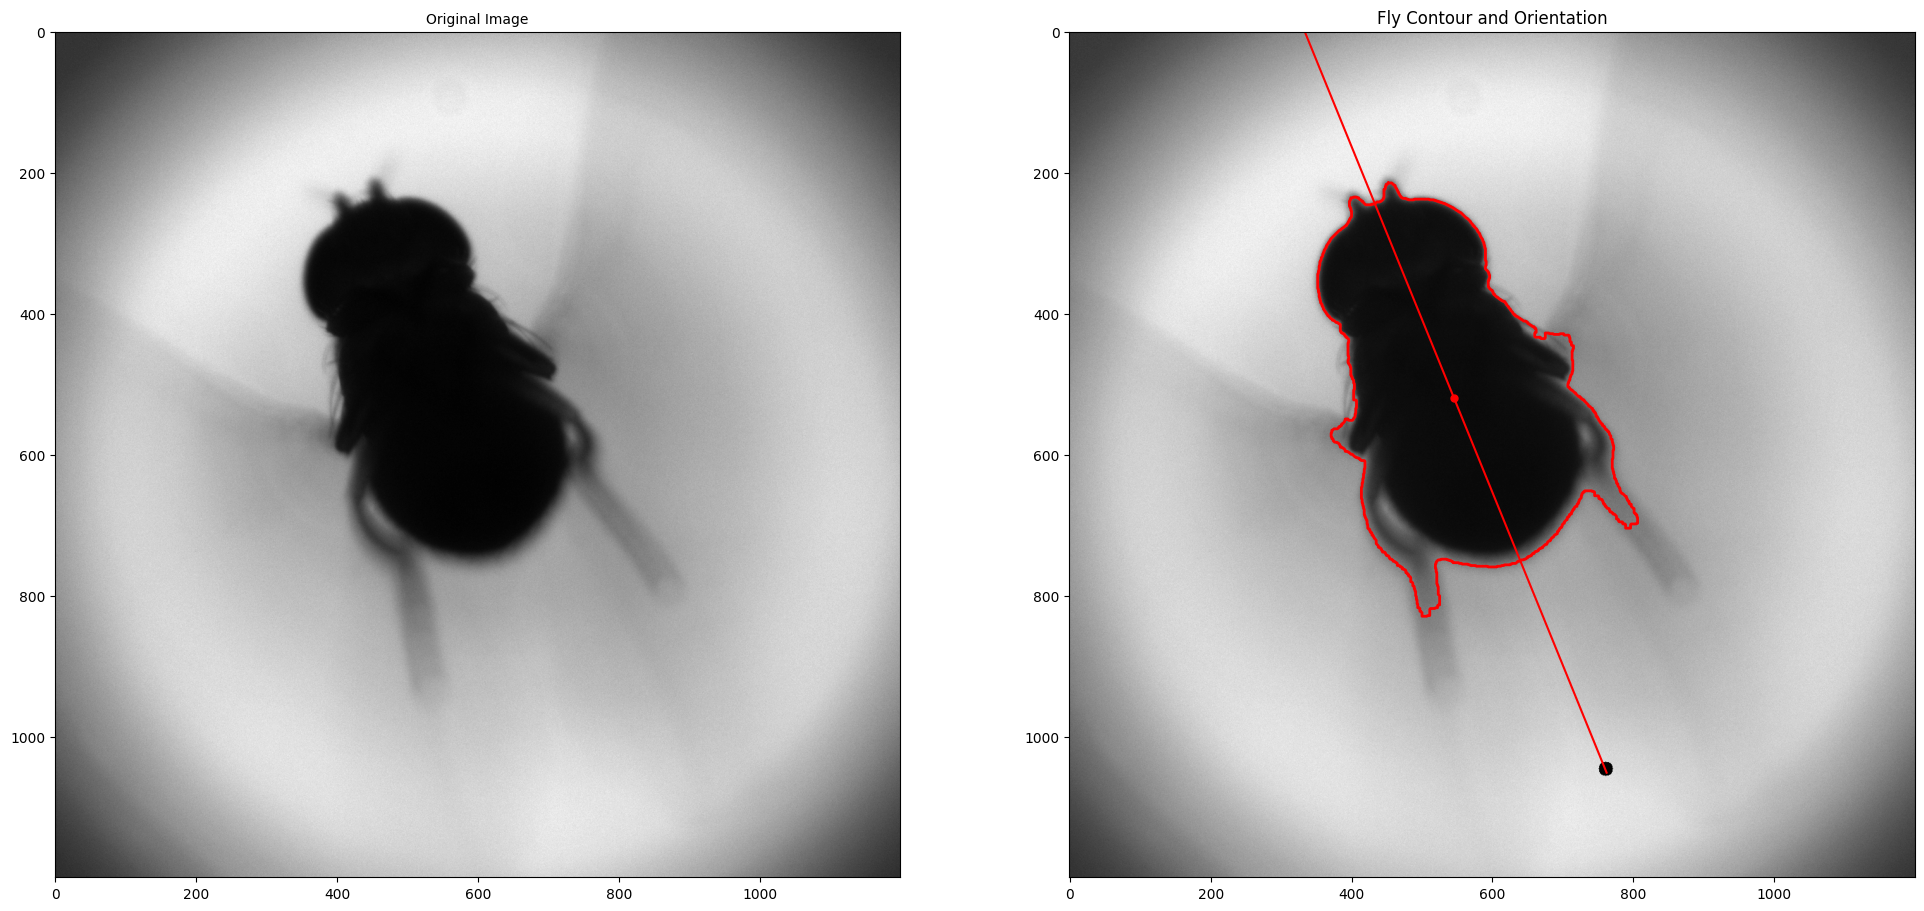

In [352]:
single_image_save('imgs/20231121124749_0061.png',display=True)

In [353]:

# single_image_save('20231227131157_0152.png',display=True)

In [354]:
# single_image_save('20231227131157_0004.png',display=True)

### TEST TWO IMAGE SAVE:
These are likely two different images of the same female fly... will fix the naming later...

height 1200
Angle Test!
Angle Value: 67.94377334440605
My Angle Value: 315.8875466888121
(759, 1047)
mask radius 570
height 1200
Angle Test!
Angle Value: 120.91954140260084
My Angle Value: 61.83908280520167
(279, 1053)
mask radius 570
(759, 1047)


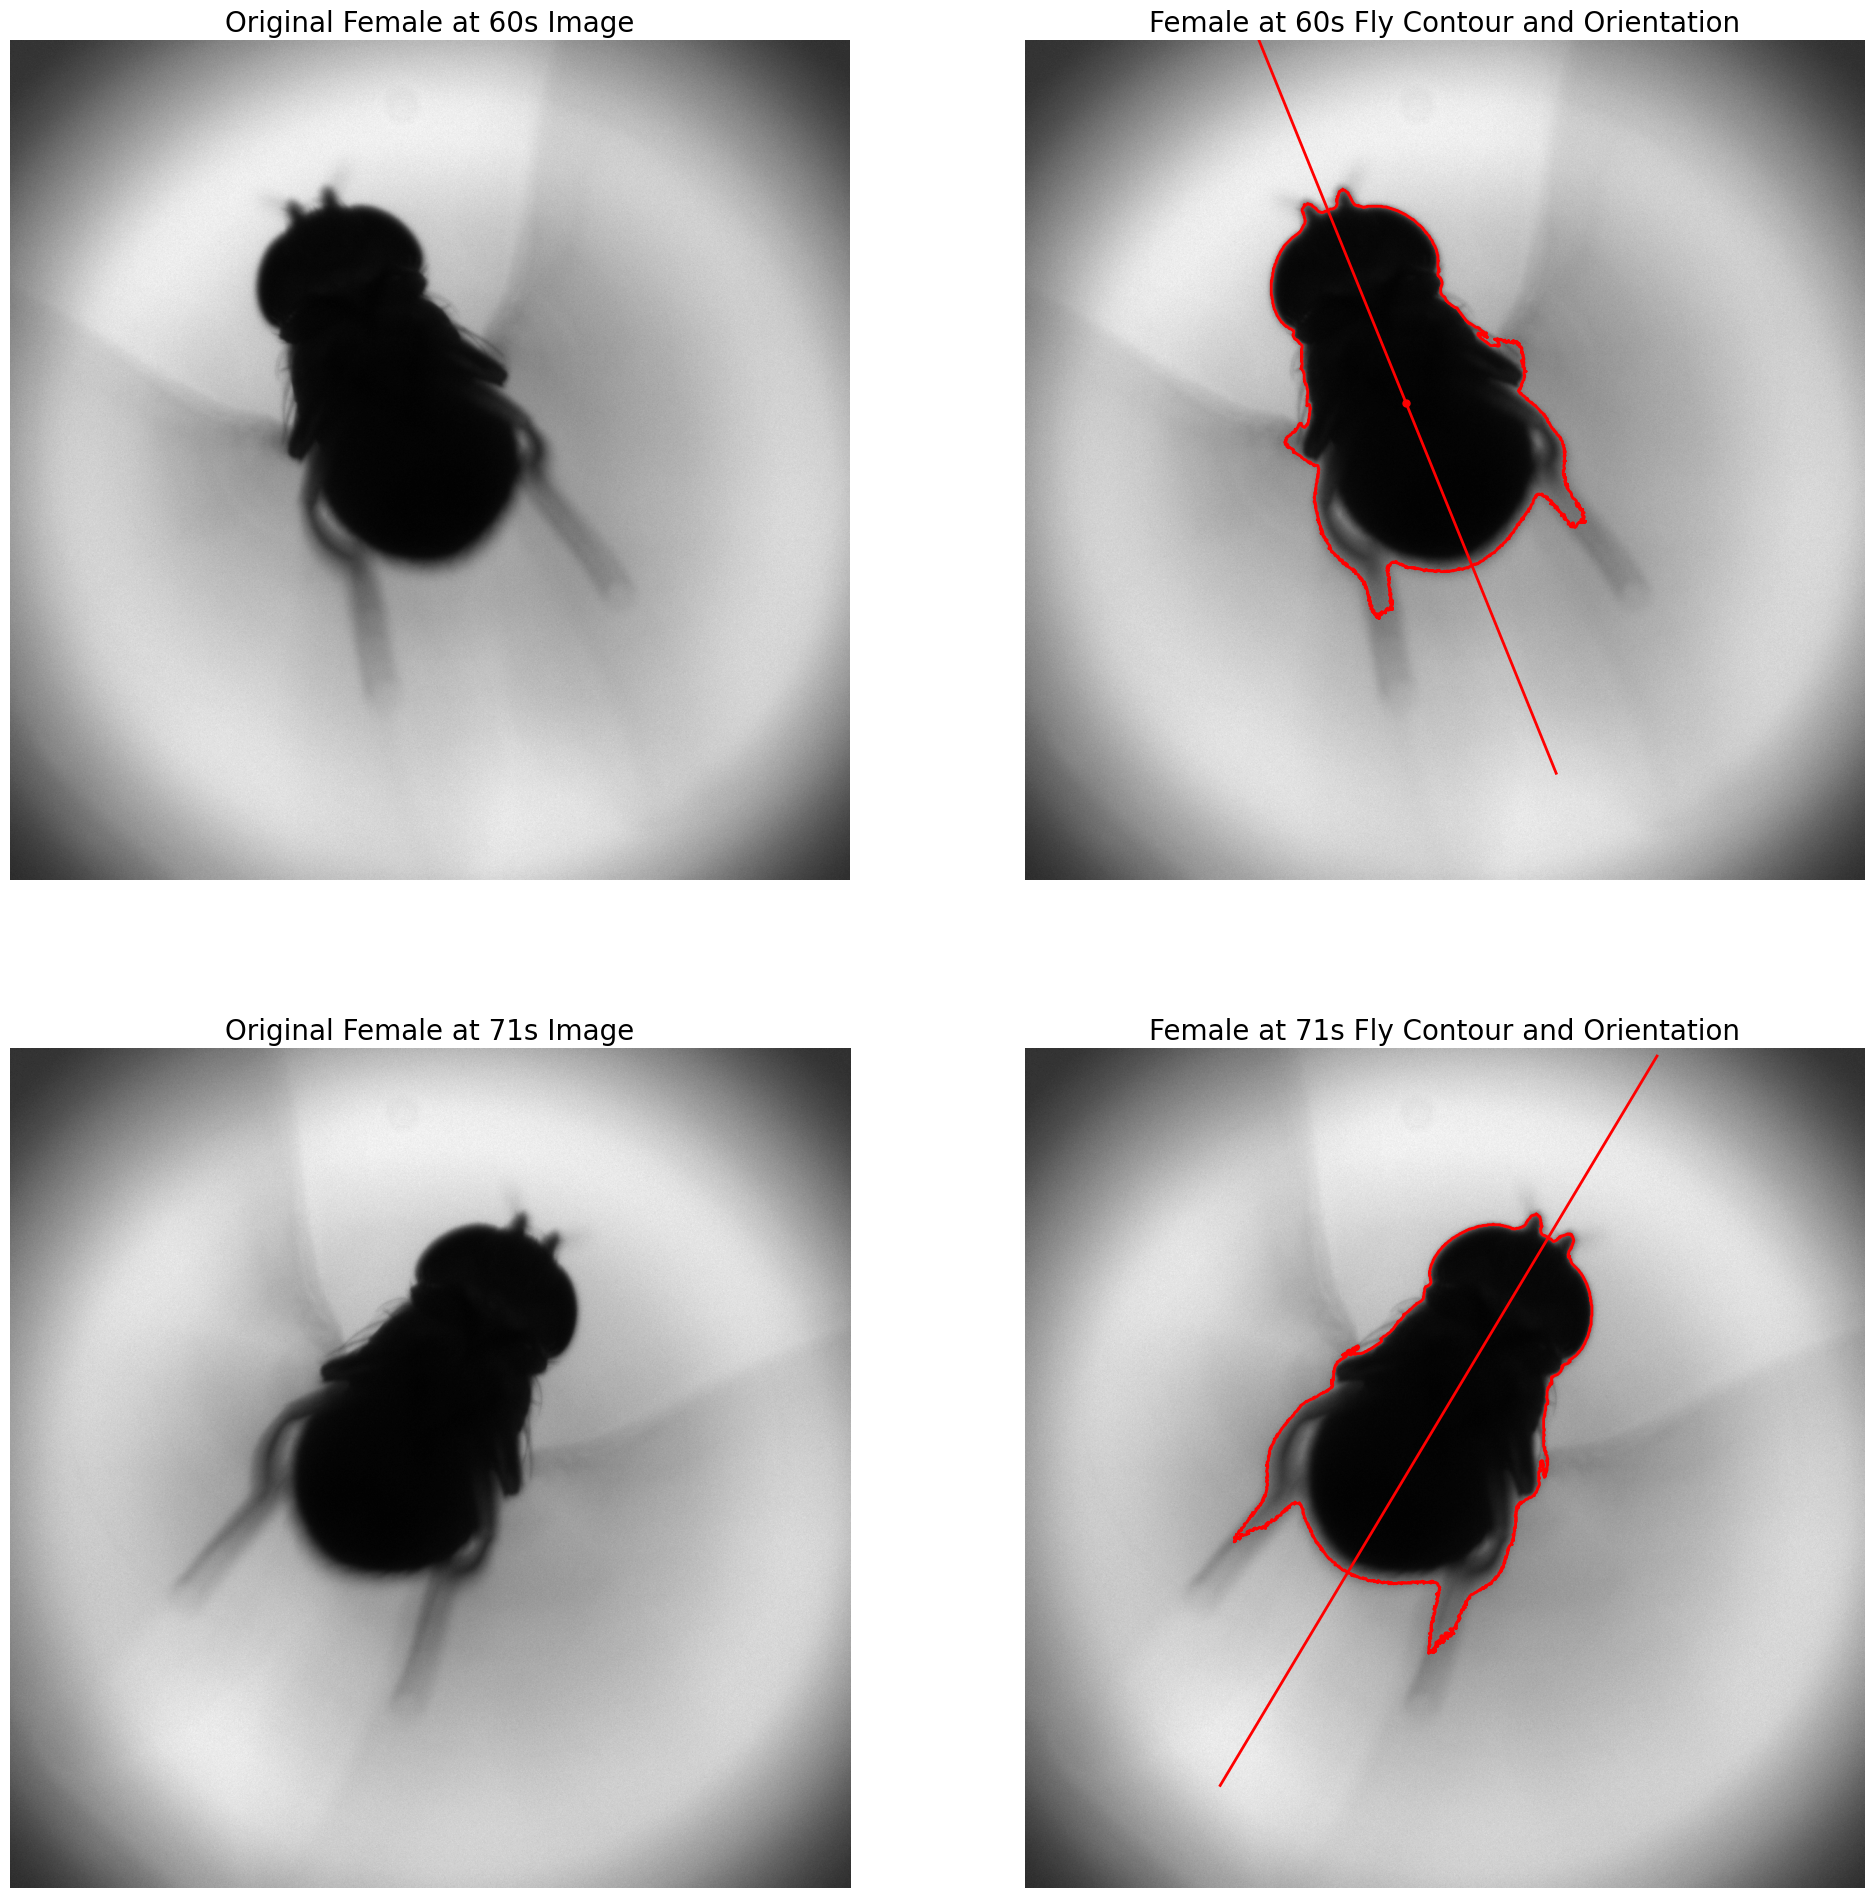

In [355]:
two_image_save('imgs/20231121124749_0061.png','imgs/20231121124749_0071.png',"Female at 60s","Female at 71s", display=True)

## It is assumed that you have a known image file or several images that you want to look at

## Here is a method to use OpenCV to go through all images and then select the best

# Develop Plots that represent the LED Position and Fly Headings over time  

The majority of this code comes from the plot_maker.py file. However, what is needed is a figure that has a plot that showcases a comparison between male and female



### Initialize some additional imports  

In [356]:
import pandas as pd
os.getcwd()

'/home/loganrower/project_repos/magno_analysis/Pub_Image_Maker/loop_led'

### Initialize the data sources for the male and female image datasets


In [357]:
# Check to make sure path is valid
# os.path.exists('/home/flyranch/data/20231228/fly3/20231228154547.txt')

In [358]:
# paths for female and male data - Lab Machine
# fem_dat_imgs = '/home/flyranch/image_data/20231228/fly3/20231228154547/'
# fem_dat_txt ='/home/flyranch/data/20231228/fly3/20231228154547.txt'
# male_dat_imgs = '/home/flyranch/image_data/20231222/fly7m/20231222110617/'
# male_dat_txt ='/home/flyranch/data/20231222/fly7m/20231222110617.txt'

In [359]:
# paths for female and male data - Local Repo Data:
fem_dat_imgs = 'imgs/20231121124749/' # ADD IN IMAGES FOR ANALYSIS LATER...
fem_dat_txt ='data/20231121124749.txt'
# male_dat_imgs = 'imgs/20231222110617/'
# male_dat_txt ='data/20231222110617.txt'

### Read in the text files to pandas dataframe

In [360]:
# # male fly heading and led position data
# df_male_dat = pd.read_csv(male_dat_txt, names = ['time','fly heading','led position'],sep = " ")
# female fly heading and led position data
df_fem_dat = pd.read_csv(fem_dat_txt, names = ['time','fly heading','led position'],sep = " ")
# print("Male Fly Heading and Led Position")
# print(df_male_dat.head(),'\n')
print("Female Fly Heading and Led Position")
print(df_fem_dat.head(70))

Female Fly Heading and Led Position
            time  fly heading  led position
0   1.700600e+09  -106.374149            -1
1   1.700600e+09  -102.859378            -1
2   1.700600e+09   -96.520980            -1
3   1.700600e+09   -90.522539            -1
4   1.700600e+09   -86.385718            -1
..           ...          ...           ...
65  1.700600e+09   -79.797662           150
66  1.700600e+09   -75.506475           150
67  1.700600e+09   -72.052165           150
68  1.700600e+09   -68.408755           150
69  1.700600e+09   -63.916090           150

[70 rows x 3 columns]


### With the data read in now we can construct the necessary plots 
To start we will being by constructing two indivual plots showcasing the LED Position and Fly Heading Over Time

#### initalized this function from plot_maker that converts the LED angle in radians from the value of its position

In [361]:
def get_LED_angle_in_rad(LED_num):
    ###2022/10/25
    ###2022/10/11
    ###2023/11/07
    ###2024/04/02
#                -180/+180 (LED 138)

#        -90 (105)                    +90 (32)

#                    0 (68)

#138 to 14: 17
#14 to 32: 18
#32 to 50: 18
#50 to 68: 18
#68 to 87: 19
#87 to 105: 18
#105 to 121: 16
#121 to 138: 17


    LED_num=LED_num.astype("float")
    LED_num[(LED_num==-1)|(LED_num==149)|(LED_num==150)]=np.nan ### for dark mode


    LED_num[(2<LED_num)&(LED_num<14)]=(np.pi-(np.pi/4/((143-138+1)+(14-2))*(143-138+1)))-((LED_num[(2<LED_num)&(LED_num<14)]-2)*(np.pi/4/((143-138+1)+(14-2))))
    LED_num[(14<=LED_num)&(LED_num<32)]=3*np.pi/4-((LED_num[(14<=LED_num)&(LED_num<32)]-14)*(np.pi/4/(32-14)))
    LED_num[(32<=LED_num)&(LED_num<50)]=np.pi/2-((LED_num[(32<=LED_num)&(LED_num<50)]-32)*(np.pi/4/(50-32)))
    LED_num[(50<=LED_num)&(LED_num<68)]=np.pi/4-((LED_num[(50<=LED_num)&(LED_num<68)]-50)*(np.pi/4/(68-50)))
    LED_num[(68<=LED_num)&(LED_num<87)]=0-((LED_num[(68<=LED_num)&(LED_num<87)]-68)*(np.pi/4/(87-68)))
    LED_num[(87<=LED_num)&(LED_num<105)]=-np.pi/4-((LED_num[(87<=LED_num)&(LED_num<105)]-87)*(np.pi/4/(105-87)))
    LED_num[(105<=LED_num)&(LED_num<121)]=-np.pi/2-((LED_num[(105<=LED_num)&(LED_num<121)]-105)*(np.pi/4/(121-105)))
    LED_num[(121<=LED_num)&(LED_num<138)]=-3*np.pi/4-((LED_num[(121<=LED_num)&(LED_num<138)]-121)*(np.pi/4/(138-121)))
    LED_num[(138<=LED_num)&(LED_num<=143)]=np.pi-((LED_num[(138<=LED_num)&(LED_num<=143)]-138)*(np.pi/4/((143-138)+(14-3))))

    LED_num[LED_num==68]=0
    LED_num[LED_num==105]=-np.pi/2
    LED_num[LED_num==138]=np.pi
    LED_num[LED_num==32]=np.pi/2
    ## 20230920
    LED_num[LED_num==14]=3*np.pi/4 
    LED_num[LED_num==50]=np.pi/4
    LED_num[LED_num==87]=-np.pi/4
    LED_num[LED_num==121]=-3*np.pi/4

    output_LED_arr=LED_num
    return output_LED_arr


In [362]:
print(get_LED_angle_in_rad(np.array([3])))
print(get_LED_angle_in_rad(np.array(([143]))))
print(get_LED_angle_in_rad(np.array(([138]))))

[2.83616003]
[2.89615573]
[3.14159265]


#### compute relevant metrics and plot 

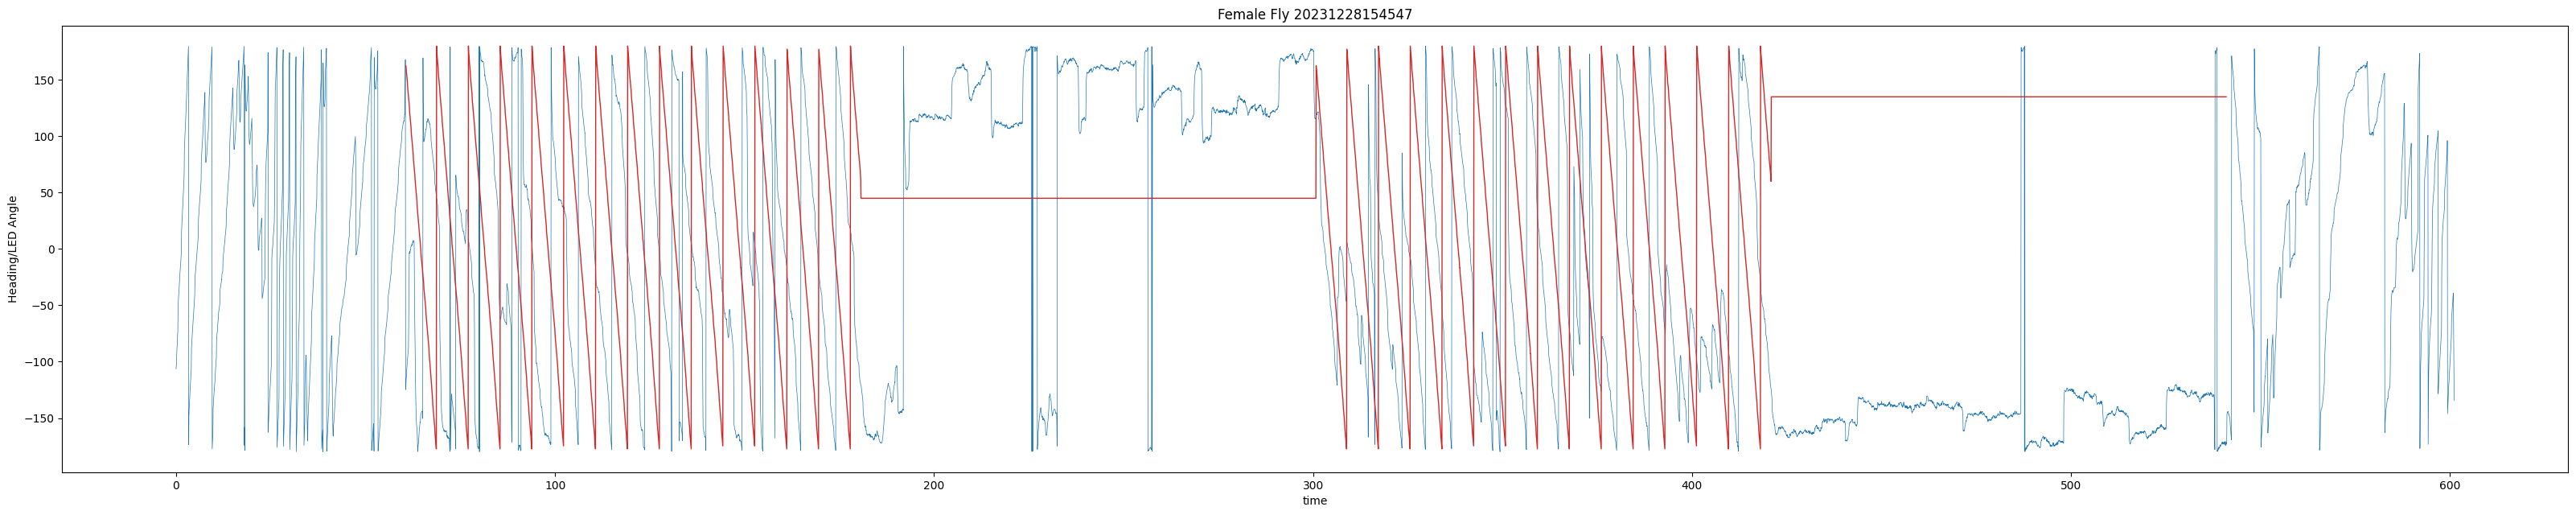

In [363]:
# Set the figure
fig = plt.figure(figsize=(36,18))
# Compute the change over time:
## male
# df_male_dat['delta-t'] = df_male_dat['time'] - df_male_dat['time'][0] 
## female
df_fem_dat['delta-t'] = df_fem_dat['time'] - df_fem_dat['time'][0] 
# Compute the LED Position in degrees:
## male
# df_male_dat['led angle'] = np.rad2deg(get_LED_angle_in_rad(df_male_dat['led position'])) 
## female
df_fem_dat['led angle'] = np.rad2deg(get_LED_angle_in_rad(df_fem_dat['led position'])) 

# plot
# plt.subplot(211)
# plt.plot(df_male_dat['delta-t'],df_male_dat['fly heading'], color = 'tab:blue', linewidth = .5, label = 'Heading')
# plt.plot(df_male_dat['delta-t'],df_male_dat['led angle'],color = 'tab:red',linewidth=1, label ='LED')
# plt.title("Male Fly 20231222110617")
# plt.xlabel("time")
# plt.ylabel("Heading/LED Angle")
plt.subplot(211)
plt.plot(df_fem_dat['delta-t'],df_fem_dat['fly heading'], color = 'tab:blue', linewidth = .5, label = 'Heading')
plt.plot(df_fem_dat['delta-t'],df_fem_dat['led angle'],color = 'tab:red',linewidth=1, label ='LED')
plt.title("Female Fly 20231228154547")
plt.xlabel("time")
plt.ylabel("Heading/LED Angle")
# plt.xlim(300,390)
fig.tight_layout(pad=15.0)
plt.show()


In [364]:
dict_sec = {}

### Based on the results of the preliminary analysis we can save the sections of the plot that we want to save
We will be able to achieve the extraction of multiple 90 second chunks as well as an additional 30s dark period for both male and female

Below are some functions that will be utilized throughout this section.

In [365]:
def find_index(idx,data,disp = 30, findstart= False):
    """
    parameters:
        idx: this is the known start or ending index
        data: this is the data that we are wanting to index
        disp: this is the total length of time we are wanting to capture
        findstart: whether or not the wanting to determine start or end index, default is set to False
    return the closest index and row
    """
    if findstart:
        # this means that need find the starting index
        target_value = data[idx] - disp
    else:
        # find end
        target_value = data[idx]+ disp

    # Calculate absolute differences between target value and the values in the DataFrame
    abs_differences = np.abs(data - target_value)
    # Find the index of the closest value
    closest_index = abs_differences.idxmin()

    # Extract the row with the closest value
    closest_row = data.loc[closest_index]
    return closest_index,closest_index


def find_index_by_value(target_value,data):
    """
    parameters:
        target_value: the value we are looking for the index of
        data: the data array we are search in
    returns the index for the particular value in that array
    """
    # Calculate absolute differences between target value and the values in the DataFrame
    abs_differences = np.abs(data - target_value)
    # Find the index of the closest value
    closest_index = abs_differences.idxmin()

    return closest_index

def find_dark_end(data):
    """
    Parameters:
        data: dataframe associated with fly
    returns the index that is end of dark and start of LED
    """
    cutoff_index = len(data['led position'])//2
    cut_data = data.loc[:cutoff_index] 
    filtered_data = cut_data[(cut_data['led position'] == -1) | (cut_data['led position'] == 150)]
    return filtered_data.index.max(),  filtered_data.index.max()+1
def get_led_position(idx, data):
    """
    Parameters:
        idx: the idx we want to classify as the start of experiment after dark period
        data: dataframe associated with fly

    returns the led position based on the idx we want to consider as the start of the experiment and the 
    data related to the fly dataframe  
    """
    
    return data['led position'].loc[idx]

def get_start_end_from_led(data):
    """
    Parameters:
        - data: dataframe associated with fly
    
    First will determine the first change in led, and based on that we will get the starting index.
    Also determined the ending index based on when it changed back to 150 aka dark mode

    Returns:
        - starting led num
        - the index for start of cycle
        - the index for end of cycle
    """
    return

### Data Parsing Methodology
- For plotting will need to inlcude the starting inidex -1...
    - it is important to note that thois might not work for the calibration sequence...however this calibration data will be largely ommitted!
    

In [494]:
# Methods Specific for Looping Experiments -> WORKING VERSION ALMOST!

## Ignore the -1 start...-> Include into dark? Right now we take start of dark as start of exp...

## Break up seections between constant LED and Looping LED

def dark_led_positions():
    """
    Parameters:
        - data -> the data for the fly.
    return start time for experiment and the dark mode
    """
    ## Start of dark period
    start_time_idx = df_fem_dat[df_fem_dat['led position'] ==150].index[0]
    start_time = df_fem_dat['time'][start_time_idx]
    ## find the point in which there is change in led_position
    end_time_idx = 0
    led_pos = df_fem_dat['led position'][start_time_idx:]
    for pnt in range(start_time_idx , len(df_fem_dat['led position'])): #checking values until we find a match
        if df_fem_dat['led position'][pnt] != 150:
            end_time_idx = pnt # the index for the dark mode ending
            break
    end_time = df_fem_dat['time'][end_time_idx]


    ## get the indicies for the the last dark period

    return start_time, start_time_idx,end_time, end_time_idx
print(dark_led_positions())
print(df_fem_dat['time'][946])
### For each section get the start and the end to create information for this grouping of data

####create the index groups...
#### check if i == i+1 if it does check when there is change from that value of i to different value...
#### if ths is not true and all values are different then will determine when there is a change to a constant value....
def sub_exp_group(start_first_led_idx):
    # get from end of dark period/start of first sub experiment to the start of the the last dark period...
    ## empty list for groups... will add start and end sub indexes as sub lists...
    fem_dict_sec = {}


    count_loop_led = 0
    count_dark = 0
    count_static_led = 0
    count_calibrate = 0
    curr_exp = ''
    sub_exp = [None,None] # start index, end index
    for pnt in range(1,len(df_fem_dat['led position'])):
        ## check difference:
        diff_led = abs( df_fem_dat['led position'][pnt] -  df_fem_dat['led position'][pnt-1])
        ## using this difference the following can be found
        ##  1. if difference is zero then we know that the points are equal to eachother. This indicates either dark mode,single LED model or,starting calibration mode (not considered currently)
            ## 1.a First check if the value is 150 and then assign the correct values...
        # print("ENTER",curr_exp, diff_led,df_fem_dat['led position'][pnt-1],df_fem_dat['led position'][pnt])
        if diff_led == 0:
            if  sub_exp[1] is None and curr_exp == 'loop' and df_fem_dat['led position'][pnt-1]== 138:
                # make sure that it is still loop...
                count_loop_led+=1
                sub_exp[1] = pnt+1
                fem_dict_sec[curr_exp+str(count_loop_led)] = [sub_exp[0],sub_exp[1]]
                print(df_fem_dat['led position'][sub_exp[0]],df_fem_dat['led position'][sub_exp[1]-1], fem_dict_sec[curr_exp+str(count_loop_led)])
                sub_exp = [None,None]
                curr_exp =''
            if df_fem_dat['led position'][pnt-1] == -1 and curr_exp == '':
                if sub_exp[0] is None:
                    curr_exp ='cali'
                    sub_exp[0]=pnt-1
            elif df_fem_dat['led position'][pnt-1] == 150:
                if sub_exp[0] is None:
                    sub_exp[0] = pnt-1
                    curr_exp = 'dark'
                
                elif curr_exp == 'dark' and (sub_exp[1] is None) and (pnt == len(df_fem_dat['led position'])-1) and (df_fem_dat['led position'][pnt]==150): 
                    # print("ENTER",pnt)
                    sub_exp[1] = pnt
                    count_dark+=1
                    fem_dict_sec["dark_"+str(count_dark)] = [sub_exp[0],sub_exp[1]]
                    print(df_fem_dat['led position'][sub_exp[0]],df_fem_dat['led position'][sub_exp[1]-1], fem_dict_sec["dark_"+str(count_dark)])
                    sub_exp = [None,None]
                    curr_exp =''

            elif df_fem_dat['led position'][pnt] == df_fem_dat['led position'][pnt-1] and df_fem_dat['led position'][pnt-1] == df_fem_dat['led position'][pnt+1]and curr_exp == '': # static LED
                if sub_exp[0] is None:
                    curr_exp ='stat'
                    sub_exp[0] = pnt-1
                


        elif diff_led > 0:
            
            # the case when curr_exp is dark, and when there is a different LED signal after the dark period
            # There is a case where between last 1-3 values could be 149...so look for end or the change from 150 to other value..
            if sub_exp[1] is None and curr_exp == 'dark' and ((pnt == len(df_fem_dat['led position'])-1) or (df_fem_dat['led position'][pnt]!=150)):
                sub_exp[1] = pnt
                count_dark+=1
                fem_dict_sec["dark"+str(count_dark)] = [sub_exp[0],sub_exp[1]]
                print(df_fem_dat['led position'][sub_exp[0]],df_fem_dat['led position'][sub_exp[1]-1], fem_dict_sec["dark"+str(count_dark)])
                sub_exp = [None,None]
                curr_exp =''
            
            elif curr_exp == 'cali' and sub_exp[1] is None and df_fem_dat['led position'][pnt-1] == -1 and df_fem_dat['led position'][pnt] ==150: # calibrate to dark mode
                sub_exp[1] = pnt
                count_calibrate+=1
                fem_dict_sec["cali"+str(count_calibrate)] = [sub_exp[0],sub_exp[1]]
                print(df_fem_dat['led position'][sub_exp[0]],df_fem_dat['led position'][sub_exp[1]-1], fem_dict_sec["cali"+str(count_calibrate)])
                sub_exp = [None,None]
                curr_exp =''
            
            elif (sub_exp[1] is None) and (curr_exp == 'stat') and (df_fem_dat['led position'][pnt] != df_fem_dat['led position'][pnt-1]):
                sub_exp[1]= pnt
                count_static_led+=1
                fem_dict_sec["stat"+str(count_static_led)] = [sub_exp[0],sub_exp[1]]
                print(df_fem_dat['led position'][sub_exp[0]],df_fem_dat['led position'][sub_exp[1]-1], fem_dict_sec["stat"+str(count_static_led)])
                sub_exp = [None,None]
                curr_exp =''


            # Primary Case: Led Loop, after ruling out the edge case of the dark mode...
            elif ((df_fem_dat['led position'][pnt] != df_fem_dat['led position'][pnt-1]) and (diff_led>=1)):
                # print(df_fem_dat['led position'][pnt-1],df_fem_dat['led position'][pnt])
                if sub_exp[0] is None and curr_exp == '':
                    curr_exp = 'loop'
                    sub_exp[0] = pnt-1
                elif curr_exp == 'loop' and sub_exp[1] is None and (diff_led>5):
                    count_loop_led+=1
                    sub_exp[1] = pnt+1
                    fem_dict_sec[curr_exp+str(count_loop_led)] = [sub_exp[0],sub_exp[1]]
                    print(df_fem_dat['led position'][sub_exp[0]],df_fem_dat['led position'][sub_exp[1]-1], fem_dict_sec["loop"+str(count_loop_led)])
                    sub_exp = [None,None]
                    curr_exp =''
        if pnt == 945:
            print(curr_exp)
            print(sub_exp)
        if pnt ==946:
            print(curr_exp)
            print(diff_led )

                
                    
    
    return fem_dict_sec

            
fem_dict_sec = sub_exp_group(dark_led_positions()[3])
print(fem_dict_sec)
print(len(fem_dict_sec))

(1700599670.19812, 9, 1700599730.243074, 946)
1700599730.243074
-1 -1 [0, 9]
dark
[9, None]
150 150 [9, 946]

147
3 3 [946, 1075]
3 3 [1074, 1202]
3 4 [1201, 1331]
4 3 [1330, 1456]
3 3 [1455, 1583]
3 3 [1582, 1707]
3 3 [1706, 1836]
3 3 [1835, 1964]
3 3 [1963, 2091]
3 3 [2090, 2217]
3 3 [2216, 2344]
3 3 [2343, 2471]
3 3 [2470, 2599]
3 3 [2598, 2727]
3 50 [2726, 2763]
50 50 [2762, 4688]
3 3 [4688, 4813]
3 3 [4812, 4937]
3 4 [4936, 5063]
4 3 [5062, 5188]
3 3 [5187, 5316]
3 3 [5315, 5444]
3 3 [5443, 5571]
3 3 [5570, 5698]
3 3 [5697, 5825]
3 3 [5824, 5953]
3 3 [5952, 6079]
3 4 [6078, 6203]
4 3 [6202, 6326]
3 3 [6325, 6449]
3 14 [6448, 6485]
14 14 [6484, 8383]
150 150 [8383, 9312]
{'cali1': [0, 9], 'dark1': [9, 946], 'loop1': [946, 1075], 'loop2': [1074, 1202], 'loop3': [1201, 1331], 'loop4': [1330, 1456], 'loop5': [1455, 1583], 'loop6': [1582, 1707], 'loop7': [1706, 1836], 'loop8': [1835, 1964], 'loop9': [1963, 2091], 'loop10': [2090, 2217], 'loop11': [2216, 2344], 'loop12': [2343, 2471], '

In [490]:
df_fem_dat['led position'][945] 

150

### Overall Visualization of the Data Range
What this section provides is the necessary functions in order to access based on preliminary visualizations which of the different sections you want to start at and end at

you can select a loop, dark or static section to start or end...Then speifiy which loop, dark or staic section it corresponds to.. For loop sections this is still in progress to develop a better method to address accessing this. However, for the static sections this is working very well as we can use the saved indexes and then use the below methods to ignore the wrongly classified static sections and only focus on the sections that have a large set of static points.




In [427]:
# Method to get the range that we want... basically will extract the specific values we want....
def find_startdata(start_led_type, start_led_num):
    """
    parameters:
        start_led_type: this is the type "dark","stat", or "loop". That is a description of the section where you are wanting to start you data access from
        start_led_num: this corresponds to visually on the plot which number of section it is ... ex: 1st static section "stat" and 1 ..... or 2nd loop section "loop" and 2.
    
    This will return the starting key for the where data will be accessed from. 
    
    """
    # look at the folloowing dictionary that is going to hold all the data that relatesx to the experimental runs 
    ## find the start...
    count = 1
    starting_key = ''
    for k in fem_dict_sec:
        if k[:4] == start_led_type and len(df_fem_dat['delta-t'][fem_dict_sec[k][0]:fem_dict_sec[k][1]]) > 2:
            if count == start_led_num:
                starting_key = k
                return starting_key
            else:
                count +=1
    return starting_key
def find_enddata(end_led_type, end_led_num):
    """
    parameters:
        end_led_type: this is the type "dark","stat", or "loop". That is a description of the section where you are wanting to end you data access from
        end_led_num: this corresponds to visually on the plot which number of section it is ... ex: 1st static section "stat" and 1 ..... or 2nd loop section "loop" and 2.
    
    This will return the end key to which point the data will be accessed until. 
    """
    # look at the folloowing dictionary that is going to hold all the data that relatesx to the experimental runs 
    ## find the start...
    count = 1
    end_key = ''
    for k in fem_dict_sec:
        if k[:4] == end_led_type and len(df_fem_dat['delta-t'][fem_dict_sec[k][0]:fem_dict_sec[k][1]]) > 2:
            if count == end_led_num:
                end_key = k
                return end_key
            else:
                count +=1
    return end_key 



##### HERE IS A TEST SHOWCASING THE CURRENT ISSUES WITH LED AGLE AGLOIRITHM
The issue is esstentially there we are unable to get the starting angle to the enbding where ending should be at 180 or before we are not doing that instead we are getting the point that is not 180.... algorithm needs to be fixed to thus accouint for this so basing on angles rather than on led position...


In [428]:
np.rad2deg(get_LED_angle_in_rad(np.array([3])))


array([162.5])

150 nan
3 162.5
Min fly angle:  -179.914404
Next Angle: -120.808199
3 162.5
4 160.0
Min fly angle:  -179.74092
Next Angle: 29.11152
3 162.5
4 160.0
Min fly angle:  -179.64543
Next Angle: -1.165344


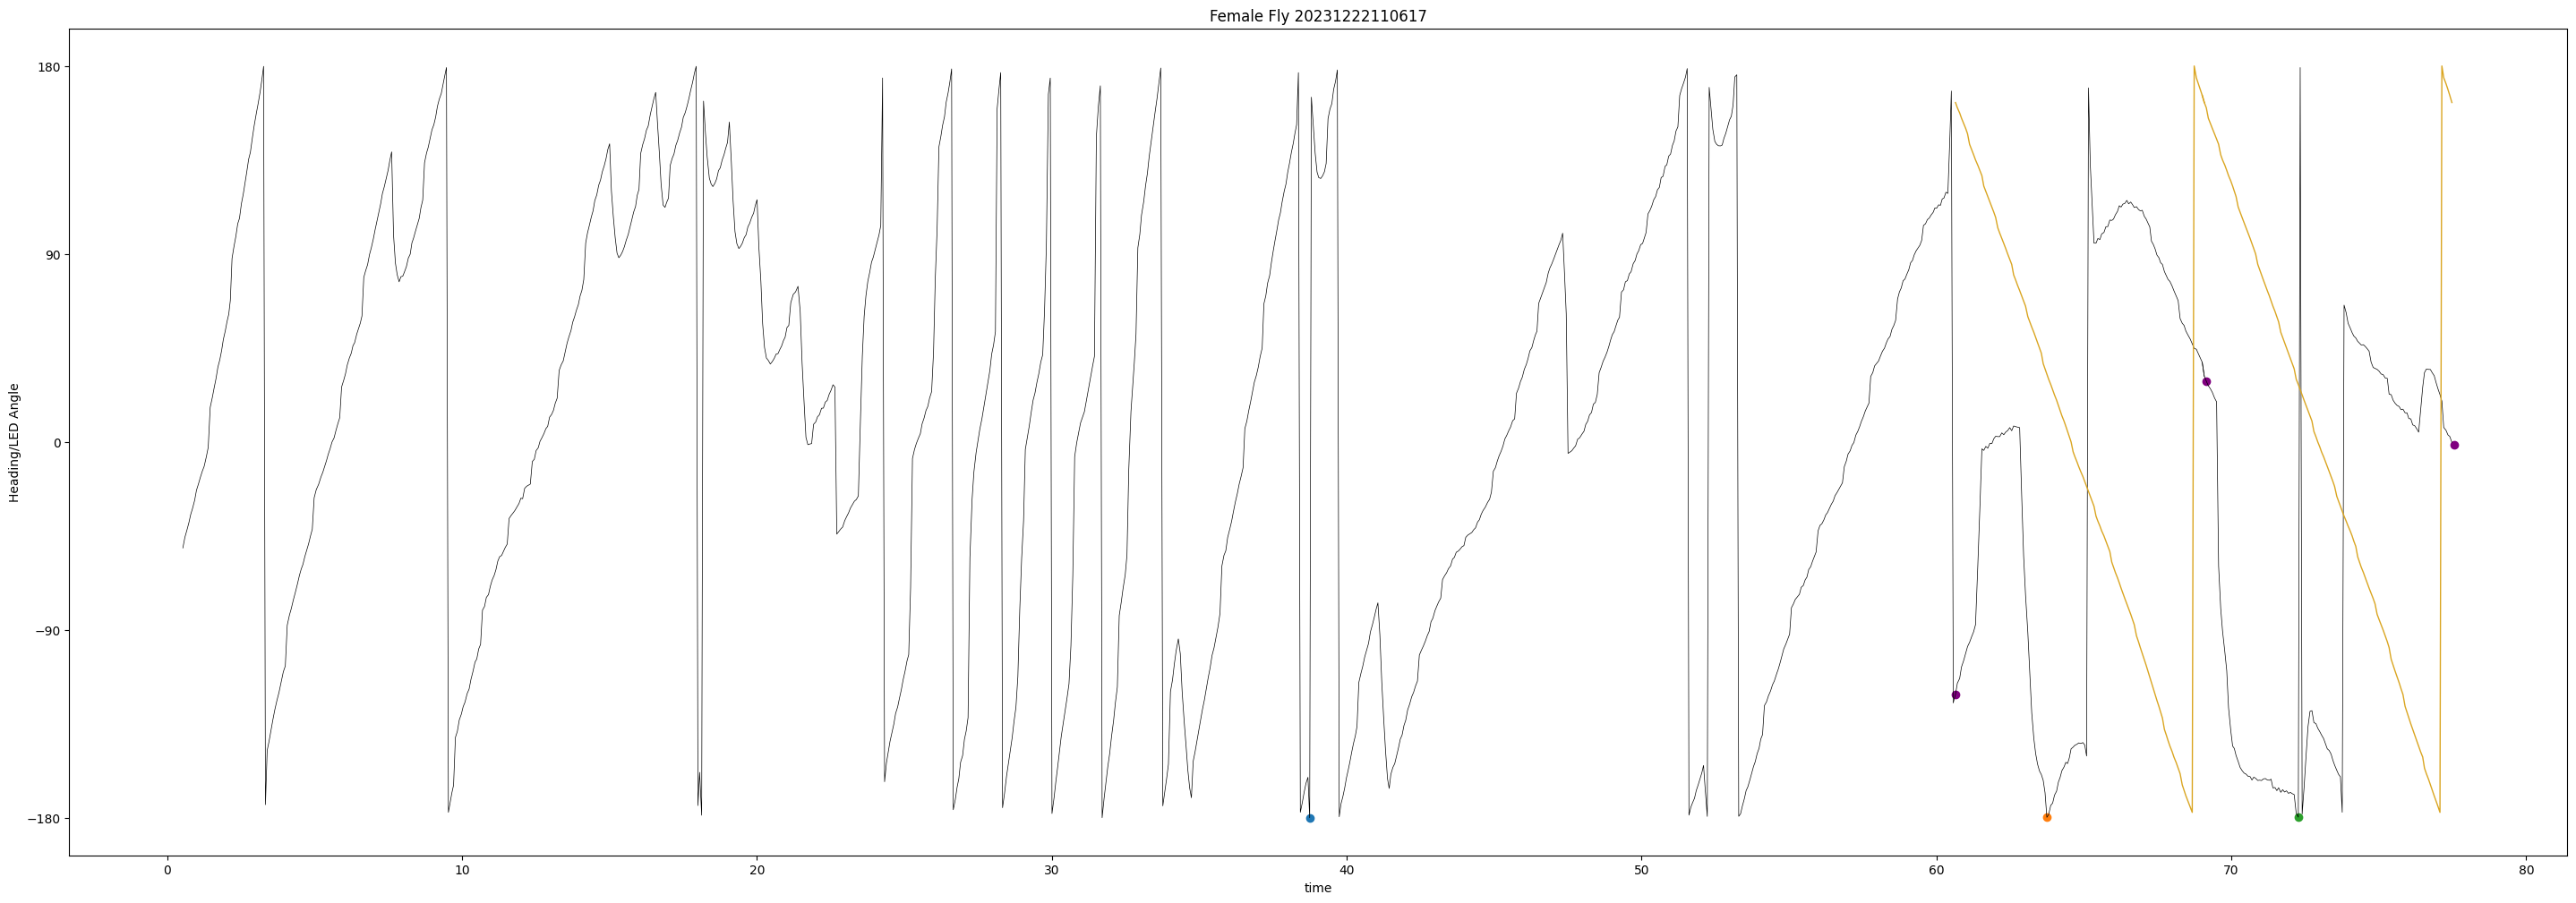

In [495]:
idx1 = (list(fem_dict_sec.keys())).index(find_startdata('dark',1))
idx2 = (list(fem_dict_sec.keys())).index(find_startdata('loop',2))
sub_groups_test = list(fem_dict_sec.keys())[idx1:idx2+1]
plt.figure(figsize=(36,12))
for count, k in enumerate(sub_groups_test):
    start_f = fem_dict_sec[k][0]
    end_f = fem_dict_sec[k][1]
    print(df_fem_dat['led position'][start_f], df_fem_dat['led angle'][start_f])
    print(df_fem_dat['led position'][end_f], df_fem_dat['led angle'][end_f])
    # plt.scatter(df_fem_dat['delta-t'][start_f],df_fem_dat['led angle'][start_f], s = 4,color = 'red')
    # plt.scatter(df_fem_dat['delta-t'][end_f], df_fem_dat['led angle'][end_f], s = 4,color = 'green')
    plt.plot(df_fem_dat['delta-t'][start_f-1:end_f],df_fem_dat['fly heading'][start_f-1:end_f],color = 'k', linewidth = .5, label = 'Heading')
    plt.plot(df_fem_dat['delta-t'][start_f-1:end_f],df_fem_dat['led angle'][start_f-1:end_f],color = 'goldenrod', linewidth = 1, label = 'LED')
    # min val ->
    print("Min fly angle: ", np.min(df_fem_dat['fly heading'][start_f:end_f]))
    print('Next Angle:', df_fem_dat['fly heading'][end_f])
    idx_min = df_fem_dat[df_fem_dat['fly heading']==np.min(df_fem_dat['fly heading'][start_f:end_f])].index[0]
    plt.scatter(df_fem_dat['delta-t'][idx_min],df_fem_dat['fly heading'][idx_min])
    plt.scatter(df_fem_dat['delta-t'][end_f],df_fem_dat['fly heading'][end_f], color ='purple')
plt.title("Female Fly 20231222110617")
plt.xlabel("time")
plt.ylabel("Heading/LED Angle")
plt.yticks(np.arange(-180,181,90))
plt.savefig('figs/test_subgrouping.svg',facecolor = 'white')

In [ ]:
data = [[1,2,3,4,5],[1,2,3,41,180,2,3],[12,21,34,56]]
for k in range(len(data)):
    for val in range(len(data[k])):
        if val == 

In [ ]:
import cmath

cmath.isclose(15,5,abs_tol=5)

False

### Generate Initial Plot of Data (Separated)

##### Data Plot

Text(0, 0.5, 'Heading/LED Angle')

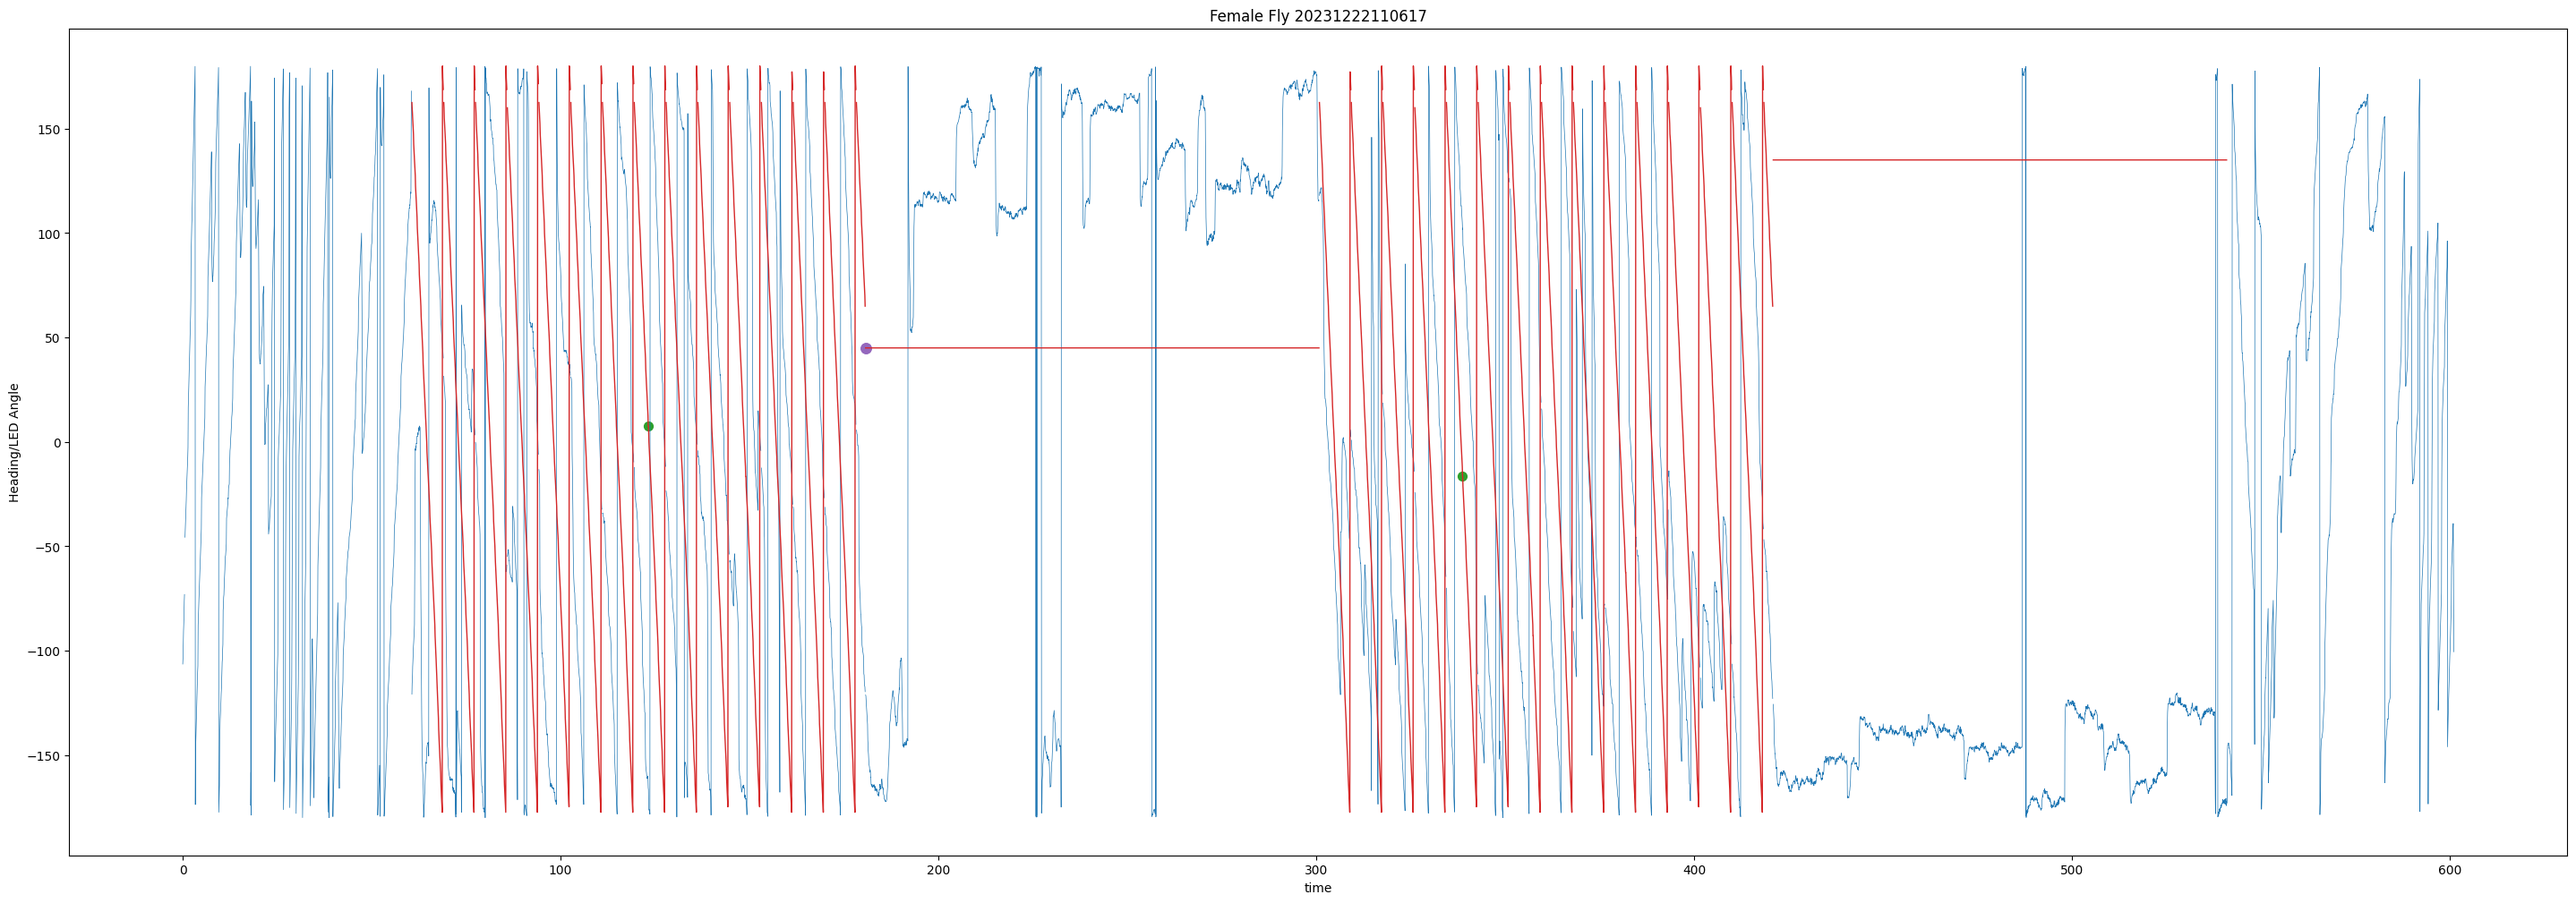

In [391]:
# Generate a list of all of these...
# initialize the figure
plt.figure(figsize=(36,12))
# iterate over the sections
for k in fem_dict_sec.keys():
    start = fem_dict_sec[k][0]
    end = fem_dict_sec[k][1]
    # print(start,end)
    plt.plot(df_fem_dat['delta-t'][start:end],df_fem_dat['fly heading'][start:end],color = 'tab:blue', linewidth = .5, label = 'Heading')
    plt.plot(df_fem_dat['delta-t'][start:end],df_fem_dat['led angle'][start:end],color = 'tab:red', linewidth = 1, label = 'LED')
plt.scatter(df_fem_dat['delta-t'][2762],df_fem_dat['led angle'][2762],s = 65, color = 'tab:purple')
plt.scatter(df_fem_dat['delta-t'][2762],df_fem_dat['led angle'][2762],s = 65, color = 'tab:purple')
plt.scatter(df_fem_dat['delta-t'][1890:1891],df_fem_dat['led angle'][1890:1891],s = 50, color = 'tab:green')
plt.scatter(df_fem_dat['delta-t'][5252:5253],df_fem_dat['led angle'][5252:5253],s = 50, color = 'tab:green')
plt.title("Female Fly 20231222110617")
plt.xlabel("time")
plt.ylabel("Heading/LED Angle")

##### Polar Plot

In [392]:
# Colors for Polar Plot:
## Loop -> Green
## Dark -> Blue
## Static -> Red

fem_dict_sec.keys()

dict_keys(['cali1', 'dark1', 'loop1', 'loop2', 'loop3', 'loop4', 'loop5', 'loop6', 'loop7', 'loop8', 'loop9', 'loop10', 'loop11', 'loop12', 'loop13', 'loop14', 'loop15', 'stat1', 'loop16', 'loop17', 'loop18', 'loop19', 'loop20', 'loop21', 'loop22', 'loop23', 'loop24', 'loop25', 'loop26', 'loop27', 'loop28', 'loop29', 'loop30', 'stat2', 'dark2'])

In [393]:
labels = ['loop','dark','static']

if 'static1'in labels:
    print(True)
else:
    print(False)

False


Female Fly Vector Strength and Mean Heading
-----------------------------



/tmp/ipykernel_4832/383979344.py:24: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend(colors, labels)


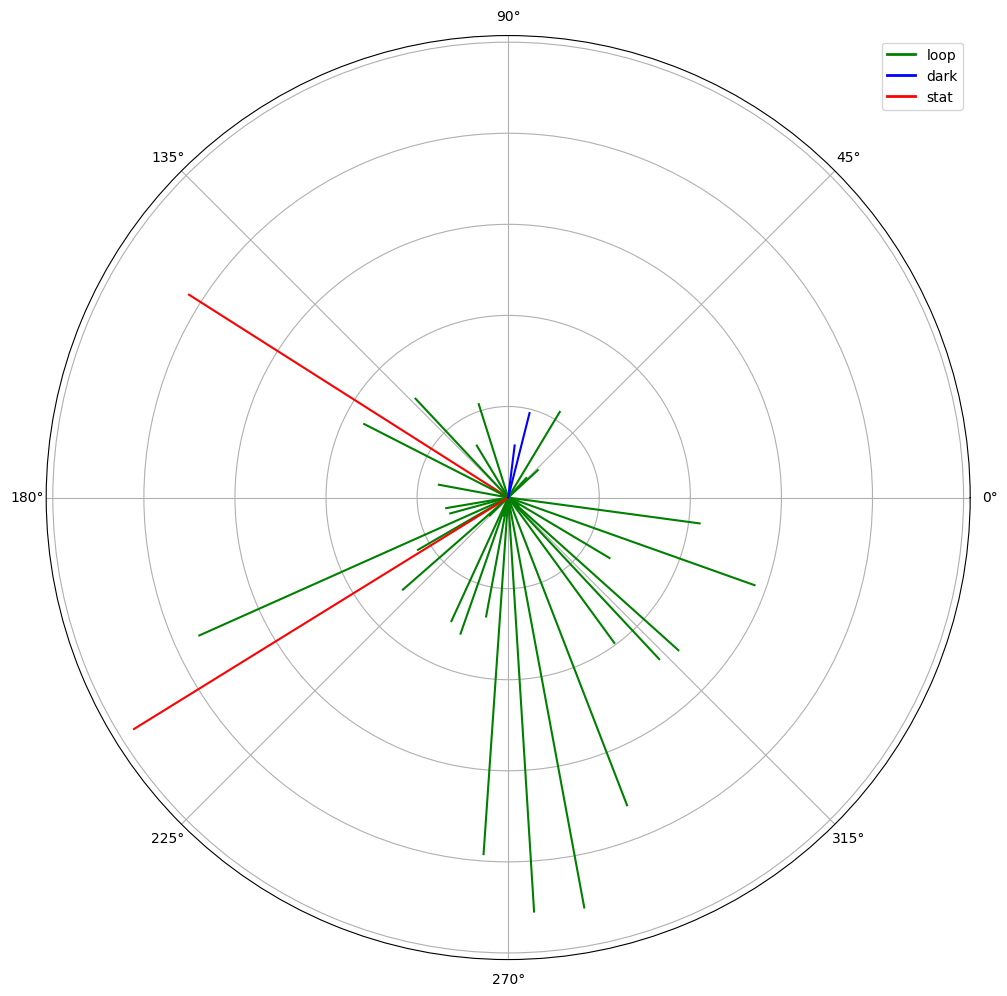

In [394]:
print("Female Fly Vector Strength and Mean Heading\n-----------------------------\n")
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(projection = 'polar')
colors = ['g','b','r']
labels = ['loop','dark','stat']
label_color =[["loop",'g'],['dark','b'],['static','r']]
label = ''
color = ''
for count, k in enumerate(list(fem_dict_sec.keys())[1:]):
    for name_idx in range(len(labels)):
        if labels[name_idx] in k:
            idx = name_idx
            color = label_color[name_idx][1]


    start_f = fem_dict_sec[k][0]
    end_f = fem_dict_sec[k][1]
    vec_str , mean_drxn = calc_mean_and_vector_strength(df_fem_dat['fly heading'][start_f:end_f])
    # print(f"Female Fly Data {df_fem_dat['delta-t'].loc[start_f]}-{df_fem_dat['delta-t'][end_f]}:")
    # print('Vector Strength:',vec_str,'\t','Mean Direction:',mean_drxn,'rads',np.rad2deg(mean_drxn),'degrees')
    # plt.polar(mean_drxn,vec_str,marker = 'o')
    ax.plot((0,mean_drxn),(0,vec_str), color = color,label = labels[name_idx])
    ax.set_yticklabels([])
plt.legend(colors, labels)
# print(leg.legend_handles)
# leg.legendHandles[0].set_color('green')
# leg.legendHandles[1].set_color('blue')
# leg.legendHandles[2].set_color('red')
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=color, lw=2, label=label) for color, label in zip(colors, labels)]
ax.legend(handles = legend_elements)
plt.savefig('figs/female_polar_plot.png',facecolor = 'white')
plt.show()

In [371]:
df_fem_dat['led position'][1891]

65

### Overall Visualization of the Data Range
What this section provides is the necessary functions in order to access based on preliminary visualizations which of the different sections you want to start at and end at

you can select a loop, dark or static section to start or end...Then speifiy which loop, dark or staic section it corresponds to.. For loop sections this is still in progress to develop a better method to address accessing this. However, for the static sections this is working very well as we can use the saved indexes and then use the below methods to ignore the wrongly classified static sections and only focus on the sections that have a large set of static points.




In [395]:
# Method to get the range that we want... basically will extract the specific values we want....
def find_startdata(start_led_type, start_led_num):
    """
    parameters:
        start_led_type: this is the type "dark","stat", or "loop". That is a description of the section where you are wanting to start you data access from
        start_led_num: this corresponds to visually on the plot which number of section it is ... ex: 1st static section "stat" and 1 ..... or 2nd loop section "loop" and 2.
    
    This will return the starting key for the where data will be accessed from. 
    
    """
    # look at the folloowing dictionary that is going to hold all the data that relatesx to the experimental runs 
    ## find the start...
    count = 1
    starting_key = ''
    for k in fem_dict_sec:
        if k[:4] == start_led_type and len(df_fem_dat['delta-t'][fem_dict_sec[k][0]:fem_dict_sec[k][1]]) > 2:
            if count == start_led_num:
                starting_key = k
                return starting_key
            else:
                count +=1
    return starting_key
def find_enddata(end_led_type, end_led_num):
    """
    parameters:
        end_led_type: this is the type "dark","stat", or "loop". That is a description of the section where you are wanting to end you data access from
        end_led_num: this corresponds to visually on the plot which number of section it is ... ex: 1st static section "stat" and 1 ..... or 2nd loop section "loop" and 2.
    
    This will return the end key to which point the data will be accessed until. 
    """
    # look at the folloowing dictionary that is going to hold all the data that relatesx to the experimental runs 
    ## find the start...
    count = 1
    end_key = ''
    for k in fem_dict_sec:
        if k[:4] == end_led_type and len(df_fem_dat['delta-t'][fem_dict_sec[k][0]:fem_dict_sec[k][1]]) > 2:
            if count == end_led_num:
                end_key = k
                return end_key
            else:
                count +=1
    return end_key 



#### Plotting Using Above Methods
Below is a plot utilizing the above methods in order to get the appropriate starting and ending indexes, based on the fact that we are looking at data from the first static period until the second static period.

In [396]:
start_idx,_ = fem_dict_sec[find_startdata('stat',1)]
_,end_idx = fem_dict_sec[find_enddata('stat',2)]

In [397]:
find_startdata('stat',1)

'stat1'

Text(0, 0.5, 'Heading/LED Angle')

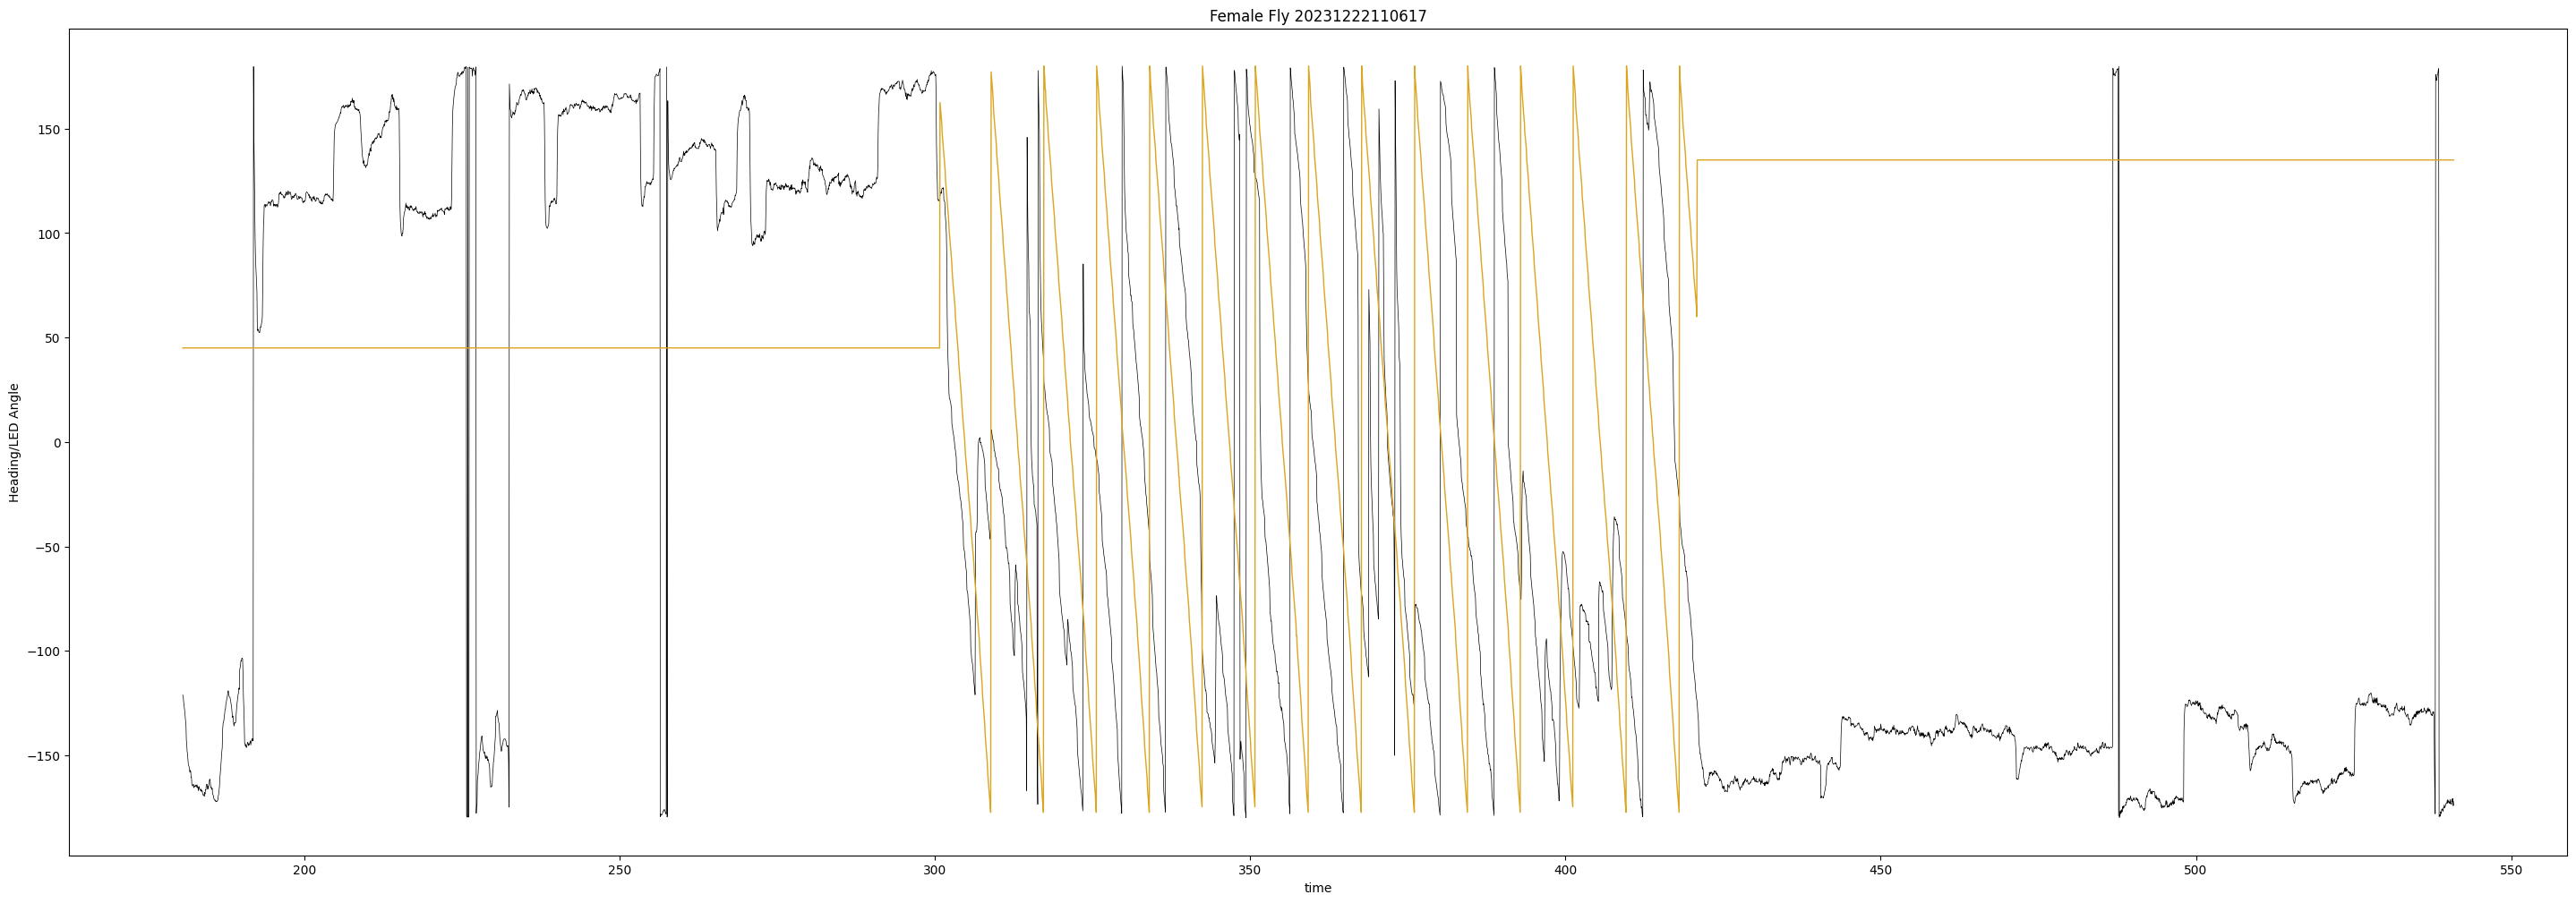

In [398]:
plt.figure(figsize=(36,12))
plt.plot(df_fem_dat['delta-t'][start_idx:end_idx],df_fem_dat['fly heading'][start_idx:end_idx],color = 'k', linewidth = .5, label = 'Heading')
plt.plot(df_fem_dat['delta-t'][start_idx:end_idx],df_fem_dat['led angle'][start_idx:end_idx],color = 'goldenrod', linewidth = 1, label = 'LED')
plt.title("Female Fly 20231222110617")
plt.xlabel("time")
plt.ylabel("Heading/LED Angle")

#### Polar Plot of this data
Prior to developing a polar plot we need to first create subgroups based on the different sub experiments that were conducted within the range that is being examined.

Using this data then the mean heading, and vector strength for each of the subgroups can be determined...

ISSUE IS SOME GROUPS SHOULD NOT EXIST BUT CURRENTLY WORKING ON THIS!

In [399]:
# get the subgroups that are appropriate for the current selection:
idx1 = (list(fem_dict_sec.keys())).index(find_startdata('stat',1))
idx2 = (list(fem_dict_sec.keys())).index(find_startdata('stat',2))
sub_groups = list(fem_dict_sec.keys())[idx1:idx2+1]

Female Fly Vector Strength and Mean Heading
-----------------------------



/tmp/ipykernel_4832/2859912323.py:25: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend(colors, labels)


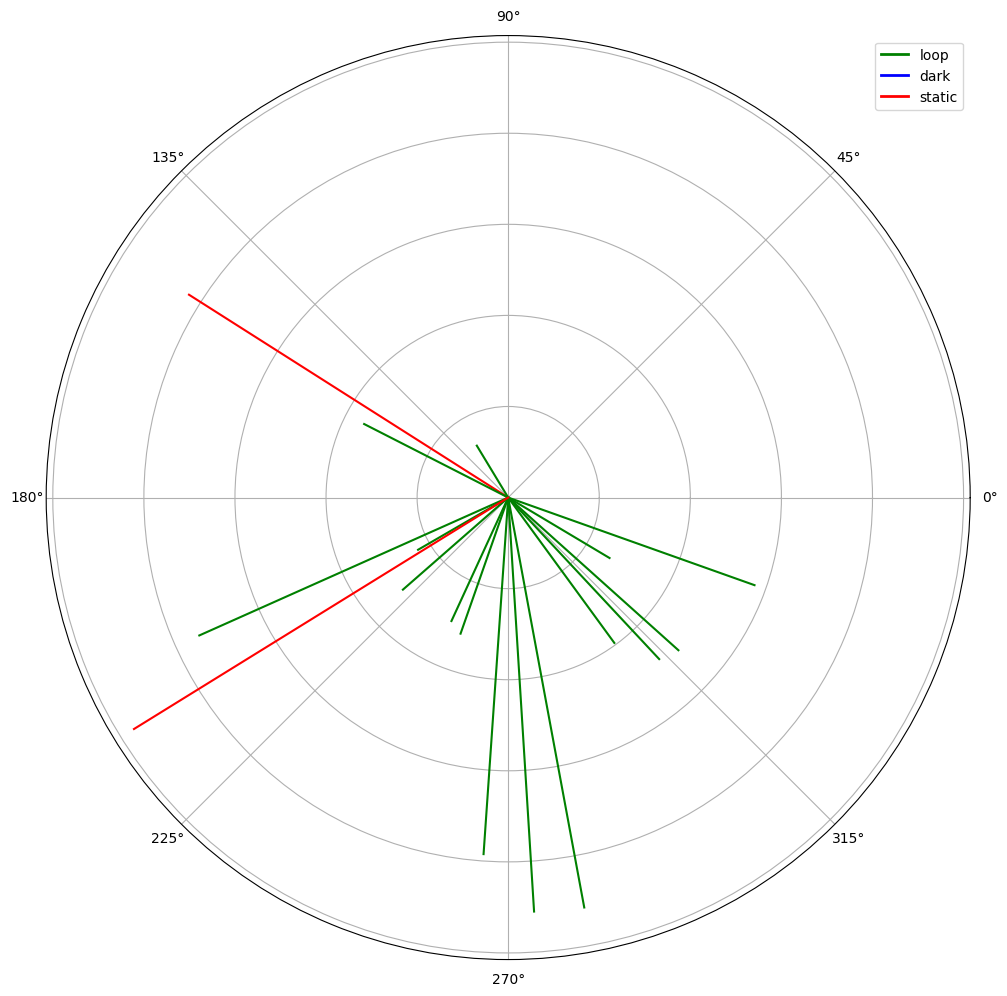

In [400]:
# polar plot methods
print("Female Fly Vector Strength and Mean Heading\n-----------------------------\n")
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(projection = 'polar')
colors = ['g','b','r']
labels = ['loop','dark','stat']
label_color =[["loop",'g'],['dark','b'],['static','r']]
label = ''
color = ''
for count, k in enumerate(sub_groups):
    for name_idx in range(len(labels)):
        if labels[name_idx] in k:
            idx = name_idx
            color = label_color[name_idx][1]


    start_f = fem_dict_sec[k][0]
    end_f = fem_dict_sec[k][1]
    vec_str , mean_drxn = calc_mean_and_vector_strength(df_fem_dat['fly heading'][start_f:end_f])
    # print(f"Female Fly Data {df_fem_dat['delta-t'].loc[start_f]}-{df_fem_dat['delta-t'][end_f]}:")
    # print('Vector Strength:',vec_str,'\t','Mean Direction:',mean_drxn,'rads',np.rad2deg(mean_drxn),'degrees')
    # plt.polar(mean_drxn,vec_str,marker = 'o')
    ax.plot((0,mean_drxn),(0,vec_str), color = color,label = labels[name_idx])
    ax.set_yticklabels([])
plt.legend(colors, labels)
# print(leg.legend_handles)
# leg.legendHandles[0].set_color('green')
# leg.legendHandles[1].set_color('blue')
# leg.legendHandles[2].set_color('red')
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=color, lw=2, label=label) for label, color in label_color]
ax.legend(handles = legend_elements)
plt.savefig('figs/female_subgroup_polar_plot.png',facecolor = 'white')
plt.show()

In [380]:
df_fem_dat[df_fem_dat['fly heading']==np.min(df_fem_dat['fly heading'][start_f:end_f])].index[0]

1122

In [381]:
def deg360to180_arr(angle_array):
    for val in range(len(angle_array)):
        print(angle_array[val])
        angle_array[val] = deg360to180(angle_array[val])
    return angle_array
# np.array((df_fem_dat['led angle'][start_f:end_f] - df_fem_dat['fly heading'][start_f:end_f]).reset_index(drop = True))



#### Plotting the mean heading on this overall plot and the offset difference between the heading and the LED position...

44.466491000000005
40.718142
37.776846000000006
36.007385
31.55060199999997
26.092278999999976
23.400544999999994
21.342797000000004
18.277366999999998
21.669719999999998
19.62599
17.62393
20.338189999999997
18.076546000000008
18.37219499999999
19.955626999999993
28.526432
55.229528
65.973077
71.528989
73.725428
78.749266
79.304013
76.86061099999998
75.707362
73.732996
72.881578
71.119803
76.389055
72.35811
71.893744
70.547023
69.395692
68.723836
67.869056
68.172509
63.671352000000006
63.684131
61.936515
66.479991
65.185309
64.421154
63.299017
61.353473
57.473655
57.222402
56.197905
56.671420000000005
54.891273
53.288453000000004
53.354132
50.465251
51.077183
50.451411
49.696733
57.288657
56.491231
54.670889
54.159108
51.83420289473684
51.05669084210527
51.48770478947368
50.3823957368421
56.691497684210525
55.02602463157895
53.73371057894737
52.6799174736842
52.09126842105263
52.034126368421056
52.006620315789476
52.5930112631579
52.18814621052631
60.76353815789474
58.10586905263158
58

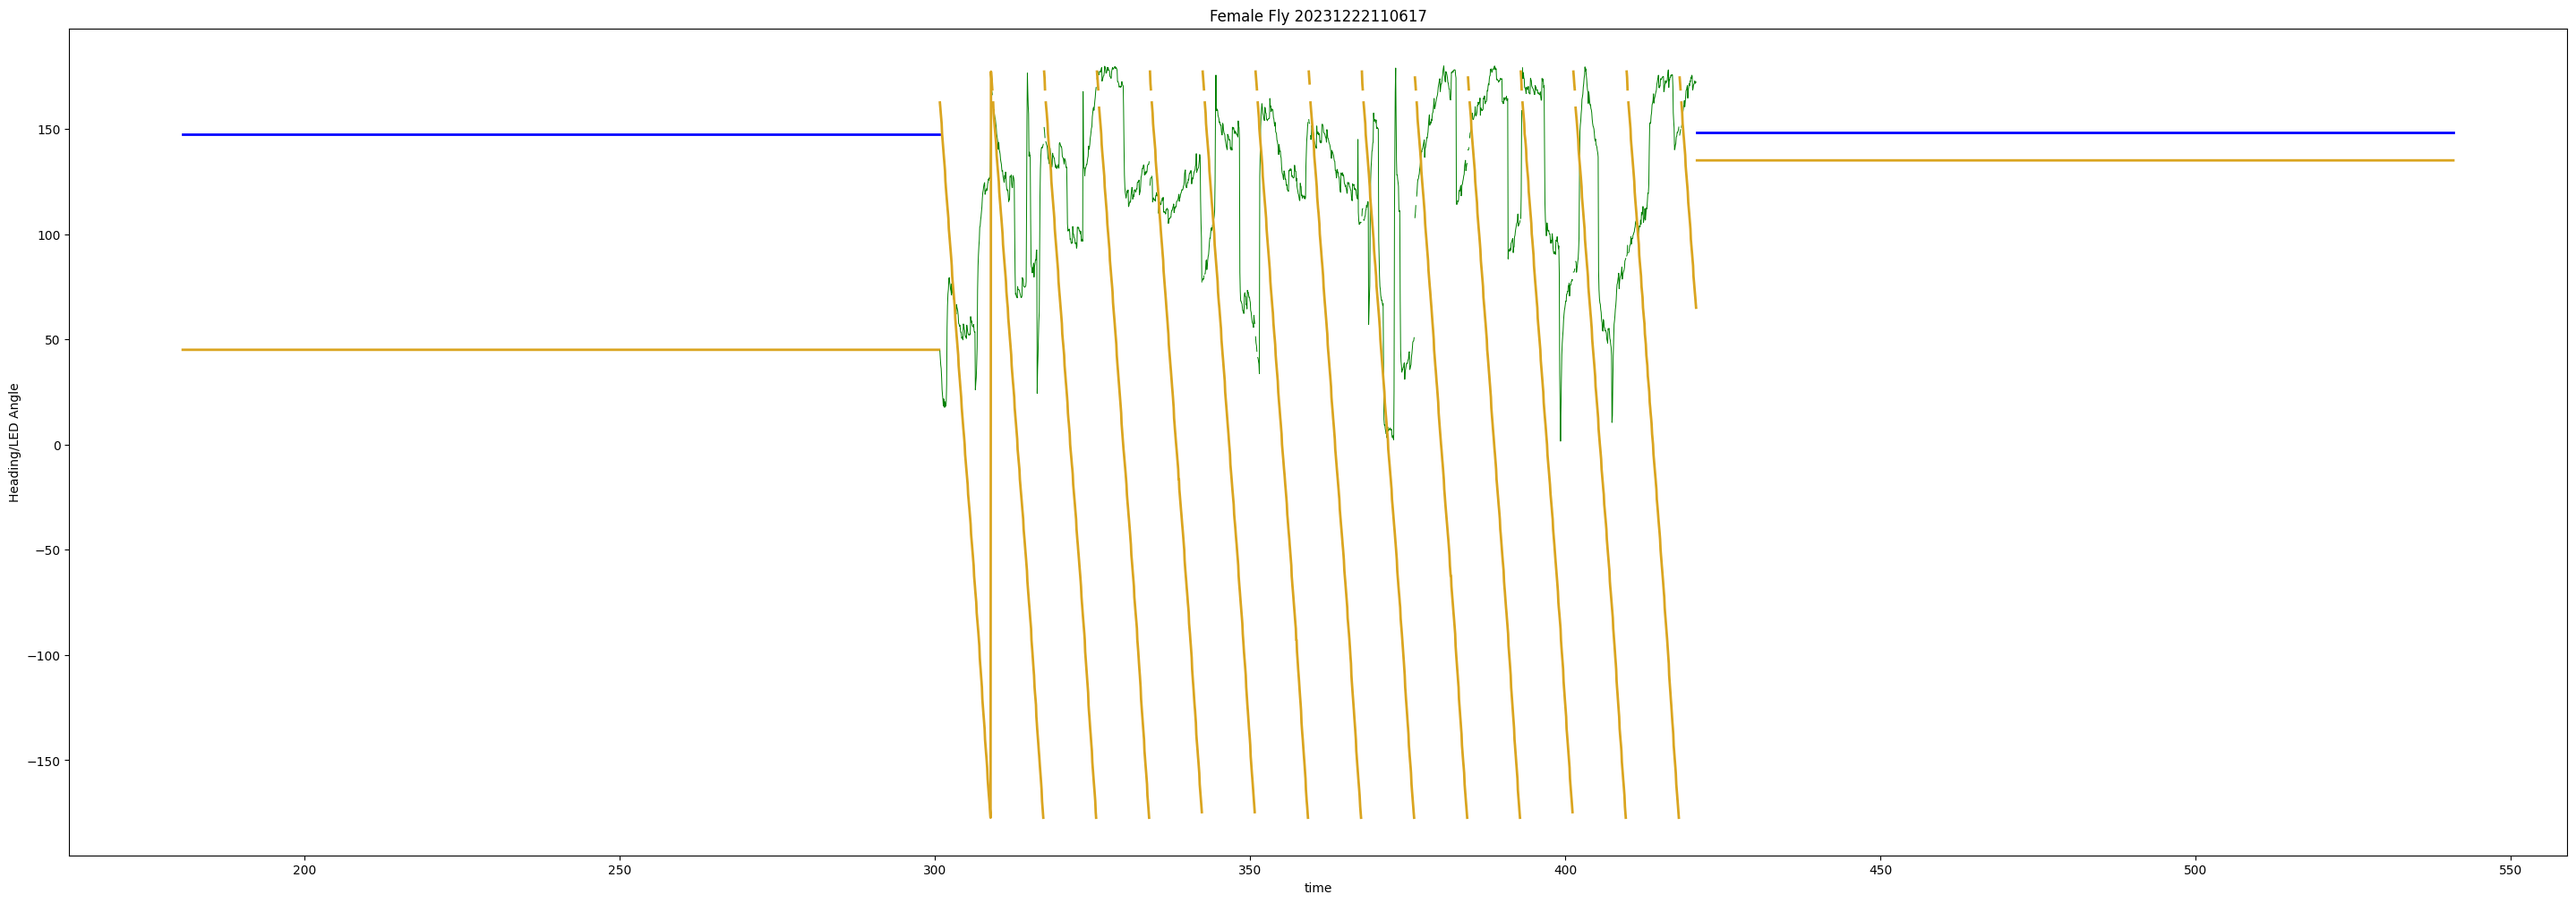

In [382]:
plt.figure(figsize=(36,12))

for count, k in enumerate(sub_groups):
    start_f = fem_dict_sec[k][0]
    end_f = fem_dict_sec[k][1]
    vec_str , mean_drxn = calc_mean_and_vector_strength(df_fem_dat['fly heading'][start_f:end_f])
    heading_og = np.rad2deg(mean_drxn)
    heading = deg360to180(heading_og)
    # print(heading_og, heading)
    # print(f"Female Fly Data {df_fem_dat['delta-t'].loc[start_f]}-{df_fem_dat['delta-t'][end_f]}:")
    # print('Vector Strength:',vec_str,'\t','Mean Direction:',mean_drxn,'rads',np.rad2deg(mean_drxn),'degrees')
    # plt.polar(mean_drxn,vec_str,marker = 'o')
    if k[:4] != 'loop':
        plt.plot((df_fem_dat['delta-t'][start_f],df_fem_dat['delta-t'][end_f]),(heading,heading),color = 'blue', linewidth = 2, label = 'Mean Heading')
    else:
        # offset difference
        # print(min(df_fem_dat['led angle'][start_f:end_f] ))
        # print(max(df_fem_dat['fly heading'][start_f:end_f]))
        offset = deg360to180_arr(np.abs(np.array((df_fem_dat['led angle'][start_f:end_f] - df_fem_dat['fly heading'][start_f:end_f]).reset_index(drop = True))))
        print(offset)
        plt.plot(df_fem_dat['delta-t'][start_f:end_f],offset,color = 'g', linewidth = .7, label = 'Offset Heading')


    # plt.plot(df_fem_dat['delta-t'][start_f:end_f],df_fem_dat['fly heading'][start_f:end_f],color = 'k', linewidth = .5, label = 'Heading')
    plt.plot(df_fem_dat['delta-t'][start_f:end_f],df_fem_dat['led angle'][start_f:end_f],color = 'goldenrod', linewidth = 2, label = 'LED')

plt.title("Female Fly 20231222110617")
plt.xlabel("time")
plt.ylabel("Heading/LED Angle")


plt.savefig('figs/female_subgroup_data_plot.png',facecolor = 'white')


In [383]:
angle =675
angle%=360
angle

315

Text(0, 0.5, 'Heading/LED Angle')

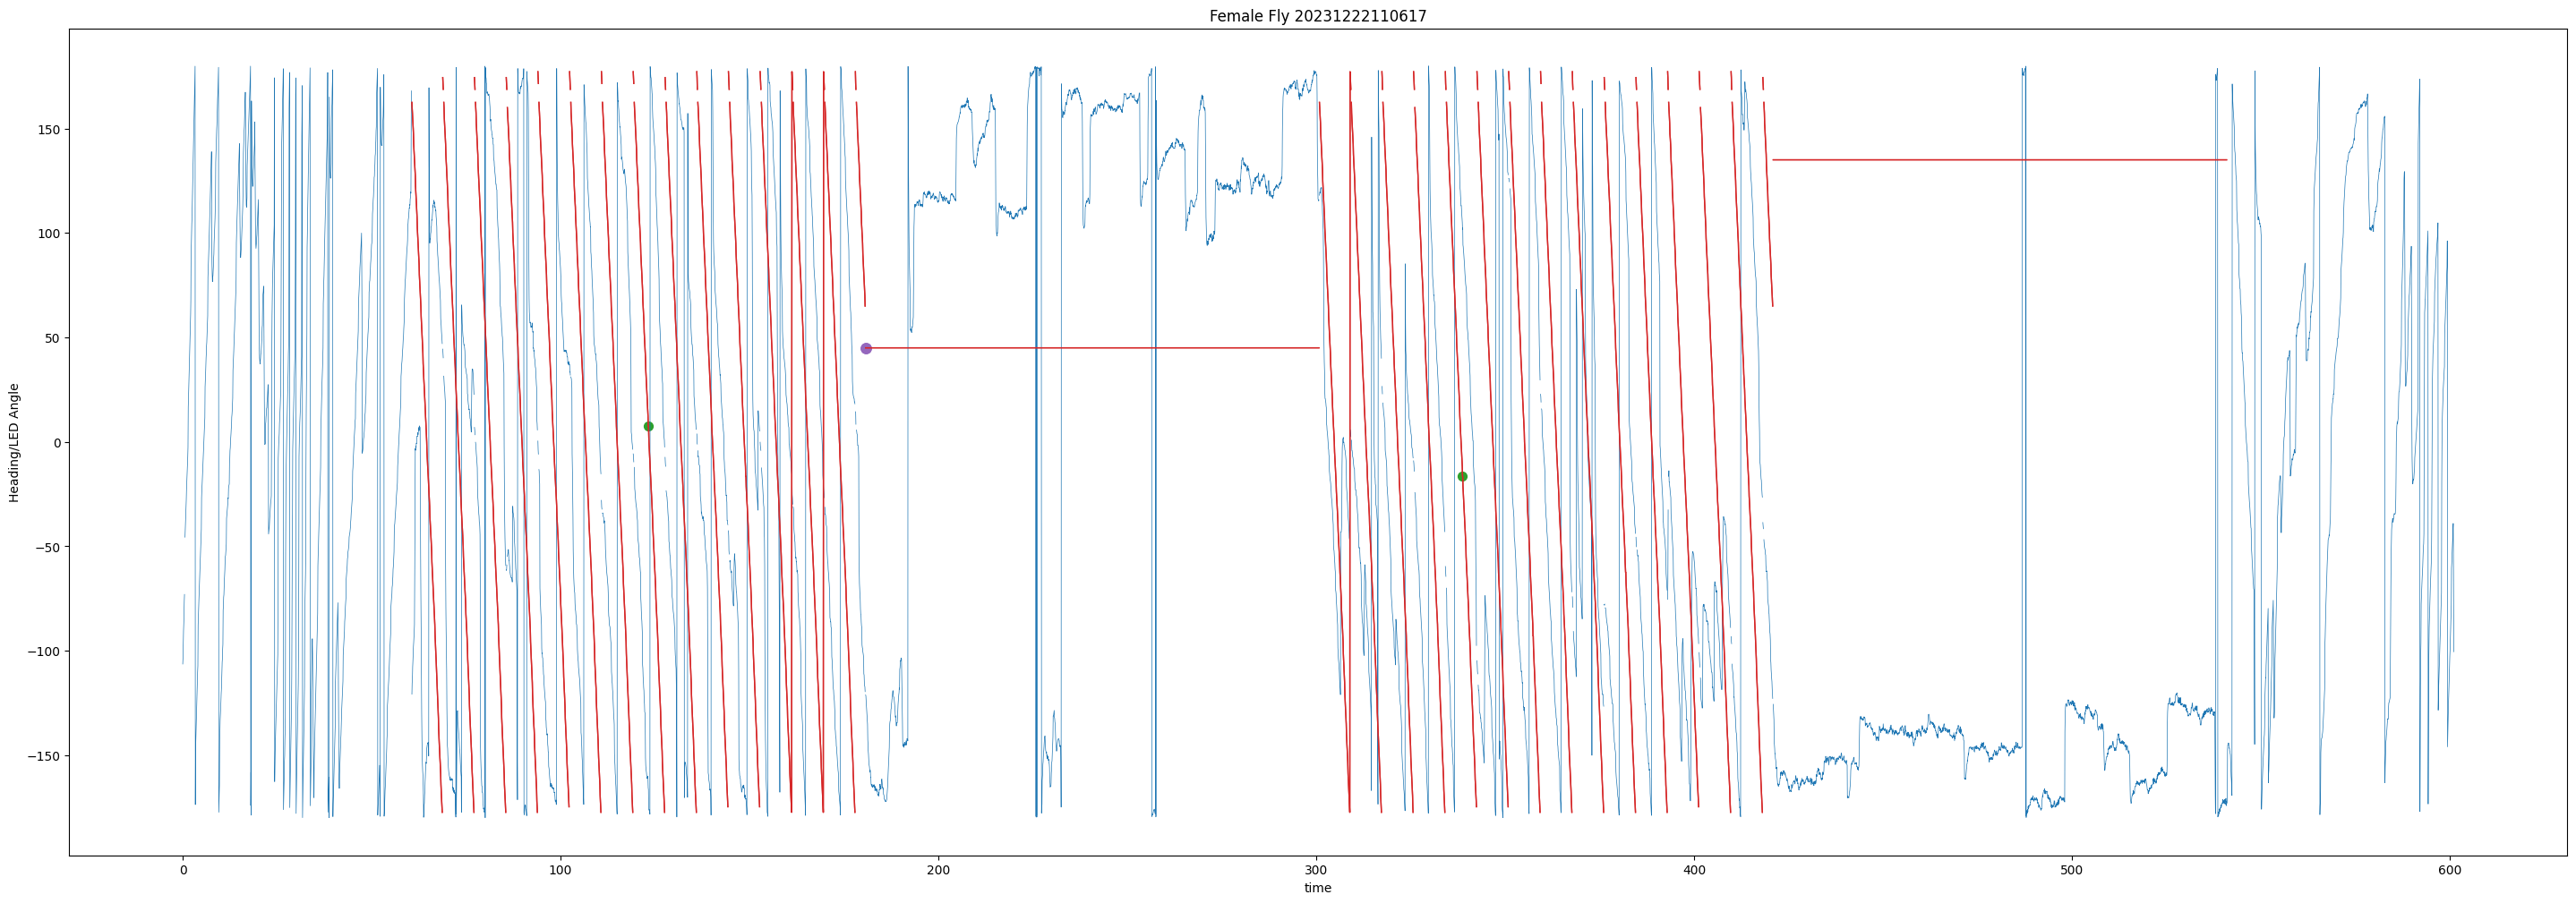

In [384]:
# Generate a list of all of these...
# initialize the figure
plt.figure(figsize=(36,12))
# iterate over the sections
for k in fem_dict_sec.keys():
    start = fem_dict_sec[k][0]
    end = fem_dict_sec[k][1]
    # print(start,end)
    plt.plot(df_fem_dat['delta-t'][start:end],df_fem_dat['fly heading'][start:end],color = 'tab:blue', linewidth = .5, label = 'Heading')
    plt.plot(df_fem_dat['delta-t'][start:end],df_fem_dat['led angle'][start:end],color = 'tab:red', linewidth = 1, label = 'LED')
    # mean heading for this group
    plt.plot(df_fem_dat['delta-t'][start:end],df_fem_dat['led angle'][start:end],color = 'tab:red', linewidth = 1, label = 'Mean Heading')
plt.scatter(df_fem_dat['delta-t'][2762],df_fem_dat['led angle'][2762],s = 65, color = 'tab:purple')
plt.scatter(df_fem_dat['delta-t'][2762],df_fem_dat['led angle'][2762],s = 65, color = 'tab:purple')
plt.scatter(df_fem_dat['delta-t'][1890:1891],df_fem_dat['led angle'][1890:1891],s = 50, color = 'tab:green')
plt.scatter(df_fem_dat['delta-t'][5252:5253],df_fem_dat['led angle'][5252:5253],s = 50, color = 'tab:green')
plt.title("Female Fly 20231222110617")
plt.xlabel("time")
plt.ylabel("Heading/LED Angle")

# Standard Plots of Data 
- standard plot of data but grab 3 sections from the sections i have previously segmented to make it easy
- get mean heading and vector strength

In [385]:
fem_dict_sec


{'cali1': [0, 8],
 'dark1': [9, 945],
 'loop1': [946, 1069],
 'loop2': [1070, 1073],
 'loop3': [1074, 1196],
 'loop4': [1197, 1200],
 'loop5': [1201, 1325],
 'loop6': [1326, 1329],
 'loop7': [1330, 1450],
 'loop8': [1451, 1454],
 'loop9': [1455, 1576],
 'loop10': [1577, 1581],
 'loop11': [1582, 1701],
 'loop12': [1702, 1705],
 'loop13': [1706, 1830],
 'loop14': [1831, 1834],
 'loop15': [1835, 1958],
 'loop16': [1959, 1962],
 'loop17': [1963, 2085],
 'loop18': [2086, 2089],
 'loop19': [2090, 2210],
 'loop20': [2211, 2215],
 'loop21': [2216, 2337],
 'loop22': [2338, 2342],
 'loop23': [2343, 2469],
 'loop24': [2470, 2597],
 'loop25': [2598, 2721],
 'loop26': [2722, 2725],
 'loop27': [2726, 2761],
 'stat1': [2762, 4687],
 'loop28': [4688, 4811],
 'loop29': [4812, 4931],
 'loop30': [4932, 4935],
 'loop31': [4936, 5056],
 'loop32': [5057, 5061],
 'loop33': [5062, 5182],
 'loop34': [5183, 5186],
 'loop35': [5187, 5309],
 'loop36': [5310, 5314],
 'loop37': [5315, 5437],
 'loop38': [5438, 5442]

Text(0, 0.5, 'Heading/LED Angle')

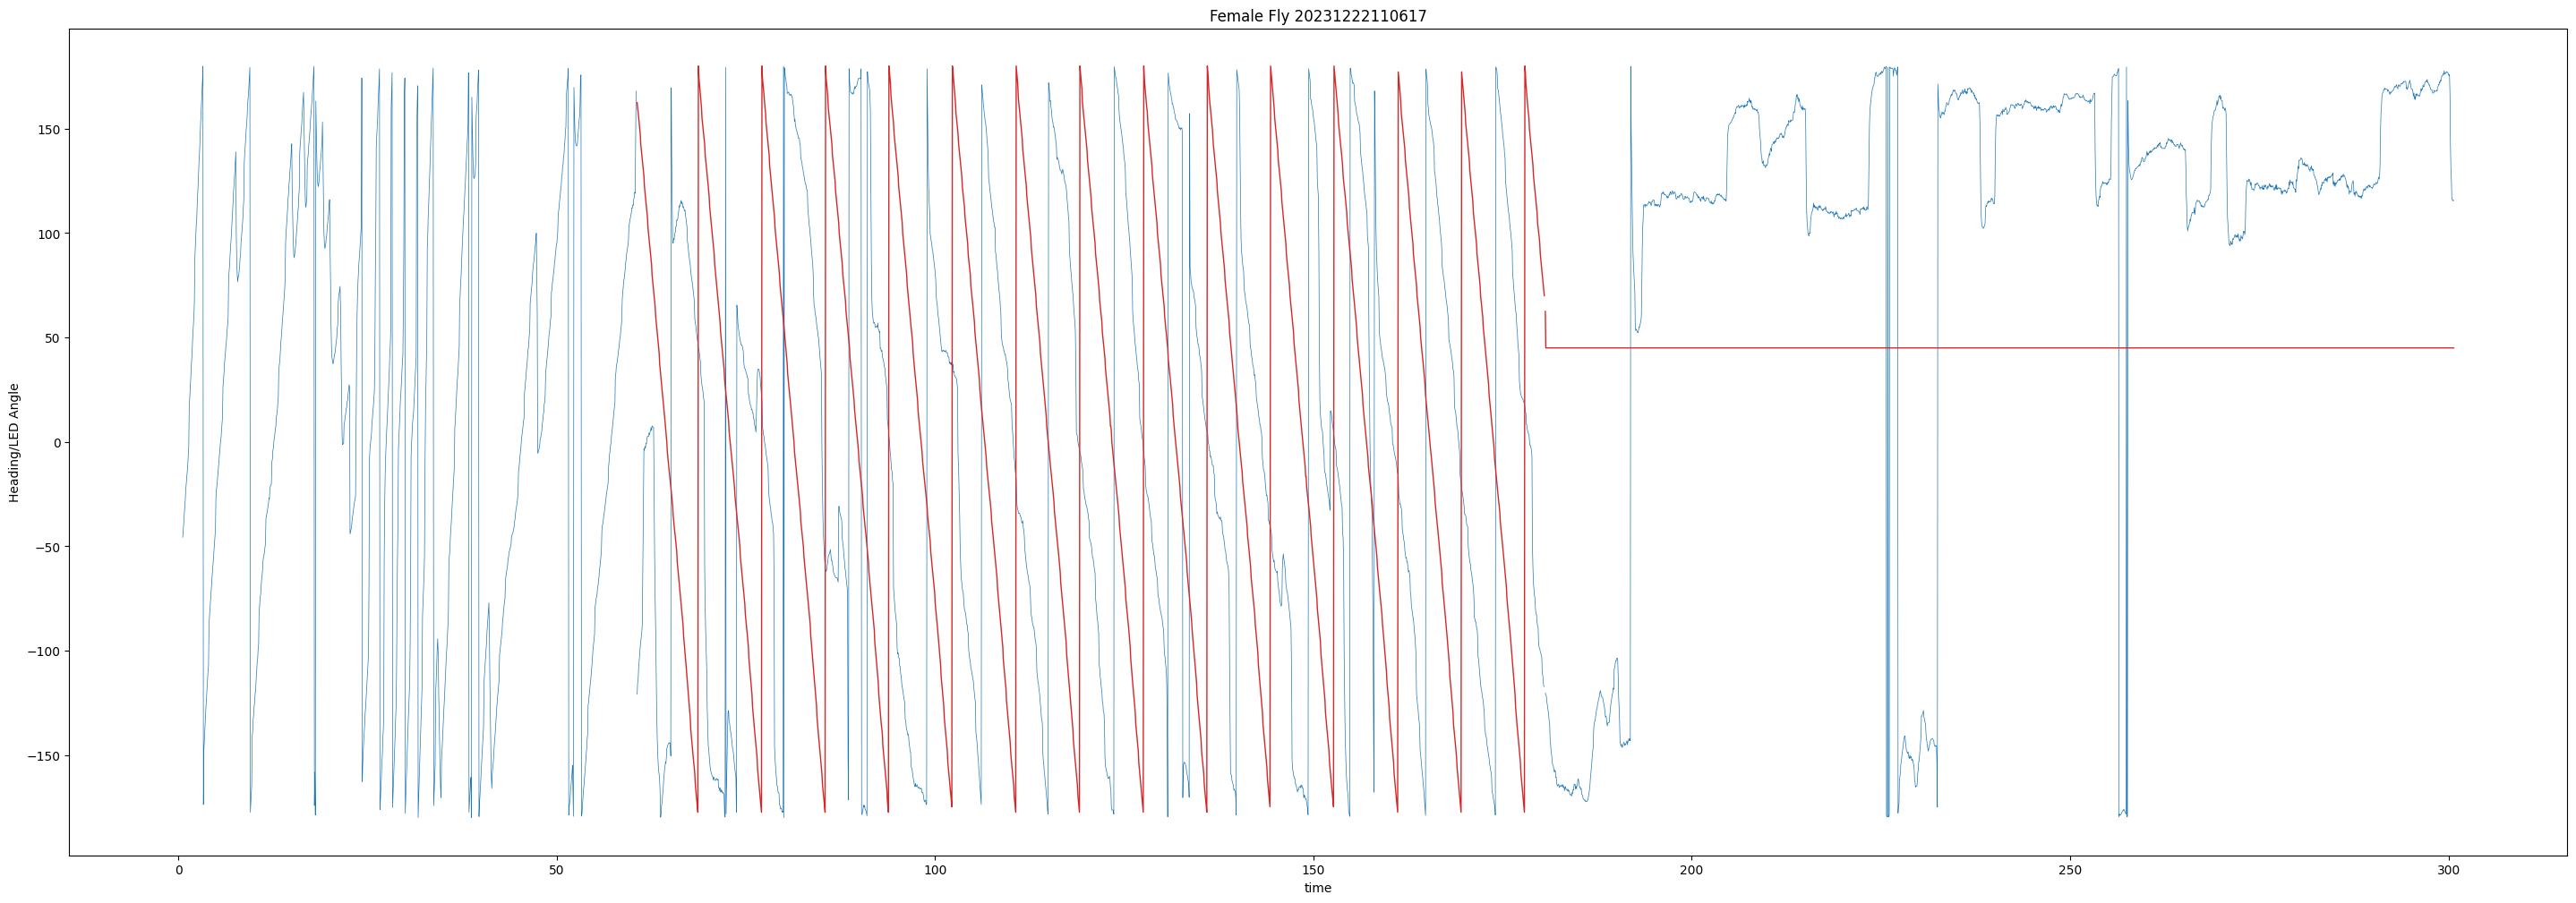

In [386]:
# Section 1: Dark
dark_start = 9
dark_end = 945
# Section 2: Loop [loop1 -loop8]
loop_start = 946
loop_end = 2760 # due to some issues with various separations manually determiend these ffrom the dictionary
# Section 3: Static
static_start = 2761
static_end = 4687


data_plot = {
    'loop':[loop_start,loop_end],
    'dark':[dark_start,dark_end],
    'static': [static_start,static_end]

}

# Generate a list of all of these...
# initialize the figure
plt.figure(figsize=(36,12))
# iterate over the sections
for k in data_plot.keys():
    start = data_plot[k][0]
    end = data_plot[k][1]
    # print(start,end)
    plt.plot(df_fem_dat['delta-t'][start:end],df_fem_dat['fly heading'][start:end],color = 'tab:blue', linewidth = .5, label = 'Heading')
    plt.plot(df_fem_dat['delta-t'][start:end],df_fem_dat['led angle'][start:end],color = 'tab:red', linewidth = 1, label = 'LED')
plt.title("Female Fly 20231222110617")
plt.xlabel("time")
plt.ylabel("Heading/LED Angle")

Female Fly Vector Strength and Mean Heading
-----------------------------



/tmp/ipykernel_4832/192761570.py:25: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend(colors, labels)


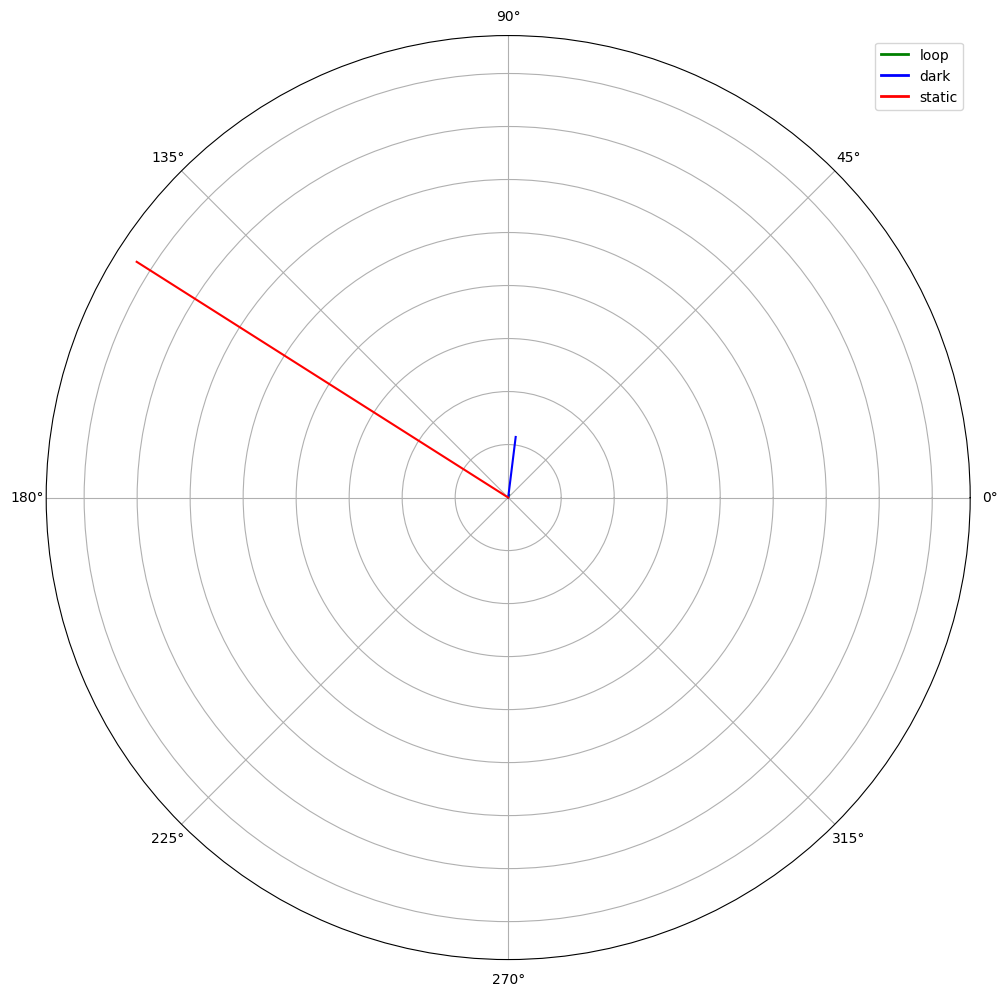

In [387]:
from matplotlib.lines import Line2D
# Shortened few sections....
print("Female Fly Vector Strength and Mean Heading\n-----------------------------\n")
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(projection = 'polar')
colors = ['g','b','r']
labels = ['loop','dark','static']
label_color =[["loop",'g'],['dark','b'],['static','r']]
label = ''
color = ''
for k in list(data_plot.keys()):
    start_f = data_plot[k][0]
    end_f = data_plot[k][1]
    for name_idx in range(len(labels)):
        if labels[name_idx] in k:
            idx = name_idx
            color = label_color[name_idx][1]

    vec_str , mean_drxn = calc_mean_and_vector_strength(df_fem_dat['fly heading'][start_f:end_f])
    # print(f"Female Fly Data {df_fem_dat['delta-t'].loc[start_f]}-{df_fem_dat['delta-t'][end_f]}:")
    # print('Vector Strength:',vec_str,'\t','Mean Direction:',mean_drxn,'rads',np.rad2deg(mean_drxn),'degrees')
    # plt.polar(mean_drxn,vec_str,marker = 'o')
    ax.plot((0,mean_drxn),(0,vec_str), color = color,label = labels[name_idx])
    ax.set_yticklabels([])
plt.legend(colors, labels)
# print(leg.legend_handles)
# leg.legendHandles[0].set_color('green')
# leg.legendHandles[1].set_color('blue')
# leg.legendHandles[2].set_color('red')

legend_elements = [Line2D([0], [0], color=color, lw=2, label=label) for color, label in zip(colors, labels)]
ax.legend(handles = legend_elements)
plt.savefig('figs/female_polar_plot.png',facecolor = 'white')
plt.show()

# EXTRAS FROM PUB IMAGE MAKER:

#### Generate plot that contains the values in these ranges
Iterate through the grouped lists and grab the respective start and end times

##### Plot for Male Fly Data 

In [388]:
# initialize the figure
plt.figure(figsize=(36,12))
# iterate over the sections
for group in male_grouped_sec:
    start = male_dict_sec[group[0]]
    end = male_dict_sec[group[1]]
    print(start,end)
    plt.plot(df_male_dat['delta-t'][start:end],df_male_dat['fly heading'][start:end],color = 'tab:blue', linewidth = .5, label = 'Heading')
    plt.plot(df_male_dat['delta-t'][start:end],df_male_dat['led angle'][start:end],color = 'tab:red', linewidth = 1, label = 'LED')

plt.title("Male Fly 20231222110617")
plt.xlabel("time")
plt.ylabel("Heading/LED Angle")

NameError: name 'male_grouped_sec' is not defined

<Figure size 3600x1200 with 0 Axes>

##### Plot Female Fly Data


In [ ]:
# initialize the figure
plt.figure(figsize=(36,12))
# iterate over the sections
for group in fem_grouped_sec:
    start = fem_dict_sec[group[0]]
    end = fem_dict_sec[group[1]]
    print(start,end)
    plt.plot(df_fem_dat['delta-t'][start:end],df_fem_dat['fly heading'][start:end],color = 'tab:blue', linewidth = .5, label = 'Heading')
    plt.plot(df_fem_dat['delta-t'][start:end],df_fem_dat['led angle'][start:end],color = 'tab:red', linewidth = 1, label = 'LED')

plt.title("Female Fly 20231222110617")
plt.xlabel("time")
plt.ylabel("Heading/LED Angle")

The first plot that was shown with the male fly showcases a period of 30s of dark and then goes into the immediate next period when there was simulated sunlight via an LED matrix.

Subsequently in the first plot there were two 90second periods of LED that were shown. In the second period we can even see the impact of the transition! 


The second plot displayed above shows a similar range of 30 seconds of dark

Between these two plots it is clear that the male seems to showcase a lot more variability in the measure and this is likely due to some possible unaccounted for flipping of the fly which is a bug of the current algorithm. 




### Plotting the Shifted Fly and LED Headings and Incorporating Mean Heading and Vector Strength
This section has the following:
- function for computing vector strength -> good
- function for computing the mean heading -> good
- plot the mean heading on the plot -> good
- a circular plot of female fly that essentially has the vector strength and mean heading for the different sections -> good

##### Helper functions for the plotting process

In [ ]:
from scipy.stats import circmean
# Vector Strength Function -> from gainexp_analysis with tweaks
## returns the vector strength and the mean heading direction in radians
def calc_mean_and_vector_strength(position_dt):
    vec_strength = 1-circvar(position_dt)
    mean_drxn=circmean(np.deg2rad(position_dt),high=np.pi, low=-np.pi)   
    return vec_strength, mean_drxn

def circvar(alpha,axis=None):
    if np.ma.isMaskedArray(alpha) and alpha.mask.shape!=():
        N = np.sum(~alpha.mask,axis)
    else:
        if axis is None:
            N = alpha.size
        else:
            N = alpha.shape[axis]
    R = np.sqrt(np.sum(np.sin(alpha),axis)**2 + np.sum(np.cos(alpha),axis)**2)/N
    V = 1-R
    return V
# Circular mean heading
def circmean_warren(alpha,axis=None ):
    # for val in range(len(alpha)):
    #     if alpha[val] < 0:
    #         alpha[val] +=360
    alpha= np.deg2rad(alpha)
    mean_angle = np.arctan2(np.nanmean(np.sin(alpha),axis),np.nanmean(np.cos(alpha),axis))
    if mean_angle<0:
        mean_angle=mean_angle+2*np.pi
    return mean_angle
def deg360to180(angle):
    if angle <0:
        angle %=360
    elif angle > 180:
        angle = 360 - angle
    
    return angle

## Example calculations
# print(circmean(df_male_dat['fly heading shift 45deg'][start:end].values))
# calc_mean_and_vector_strength(df_male_dat['fly heading shift 45deg'][start:end].values)

##### Perform the Shift in Fly Heading Based on LED
- Created a new column in each dataframe that relates to the shifted heading by the LED accounting for any wrapping

In [ ]:
## Now we will incorporate what we have with the mean heading and vector strength onto this plot and on separate plots...
## male data 45 degree shift and adjustment 
df_male_dat['fly heading shift'] = df_male_dat['fly heading']
for idx in range(len(df_male_dat['fly heading'])):
    # Apply the 45-degree shift directly in degrees
    shifted_heading = df_male_dat['fly heading'].iloc[idx] + (-1*male_led_heading)
    # Correctly wrap the heading within the -180 to 180 range
    if shifted_heading > 180:
        shifted_heading -= 360
    elif shifted_heading < -180:
        shifted_heading += 360
    # Update the DataFrame
    df_male_dat['fly heading shift'].iloc[idx] = shifted_heading

## shifted female data by: 135 degrees 
df_fem_dat['fly heading shift'] = df_fem_dat['fly heading']
for idx in range(len(df_fem_dat['fly heading'])):
    # Apply the 45-degree shift directly in degrees
    shifted_heading = df_fem_dat['fly heading'].iloc[idx] + (-1*fem_led_heading)
    # Correctly wrap the heading within the -180 to 180 range
    if shifted_heading > 180:
        shifted_heading -= 360
    elif shifted_heading < -180:
        shifted_heading += 360
    # Update the DataFrame
    df_fem_dat['fly heading shift'].iloc[idx] = shifted_heading

In [ ]:
# initialize the figure
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(36,24))
# iterate over the sections
for group in range(len(male_grouped_sec)):
    ## start and end for male fly
    start_m = male_dict_sec[male_grouped_sec[group][0]]
    end_m = male_dict_sec[male_grouped_sec[group][1]]
    ## start and end for female fly
    start_f = fem_dict_sec[fem_grouped_sec[group][0]]
    end_f = fem_dict_sec[fem_grouped_sec[group][1]]
    # male fly plots:
    ## 45 degree shifted heading
    ax1.plot(df_male_dat['delta-t'][start_m:end_m],df_male_dat['fly heading shift'][start_m:end_m],color = 'black', linewidth = .5, label = 'Shifted Heading')
    ## Original heading
    # ax1.plot(df_male_dat['delta-t'][start_m:end_m],df_male_dat['fly heading'][start_m:end_m],color = 'tab:green', linewidth = .5, label = 'OriginalHeading')
    ## the LED Heading 
    ax1.plot(df_male_dat['delta-t'][start_m:end_m],df_male_dat['led angle'][start_m:end_m]+(-1*male_led_heading),color = 'green', linewidth = 2, label = 'LED')
    ## add in the average heading and vector strength 45 degree shift...
    vect_str,heading = calc_mean_and_vector_strength(df_male_dat['fly heading shift'][start_m:end_m])
    heading =  np.rad2deg(heading)
    ## horizontal plot to represent the mean heading
    ax1.plot((df_male_dat['delta-t'].loc[start_m],df_male_dat['delta-t'].loc[end_m]),(heading,heading),color = 'blue', linewidth = 2, label = 'Mean Heading')

    # female fly plots, plots at same time as the male data but ommits female group 1 section.
    if group != 1:
        ## 135 degree shifted heading
        ax2.plot(df_fem_dat['delta-t'][start_f:end_f],df_fem_dat['fly heading shift'][start_f:end_f],color = 'black', linewidth = .5, label = 'Shifted Heading')
        ## Original heading
        # ax2.plot(df_fem_dat['delta-t'][start_f:end_f],df_fem_dat['fly heading'][start_f:end_f],color = 'tab:orange', linewidth = .5, label = 'OriginalHeading')
        ## the LED Heading 
        ax2.plot(df_fem_dat['delta-t'][start_f:end_f],df_fem_dat['led angle'][start_f:end_f]+ (-1*fem_led_heading),color = 'green', linewidth = 2, label = 'LED')
        ## add in the average heading and vector strength 135 degree shift...
        vect_str,heading = calc_mean_and_vector_strength(df_fem_dat['fly heading shift'][start_f:end_f])
        heading =  np.rad2deg(heading)
        print(heading)
        ## horizontal plot to represent the mean heading
        ax2.plot((df_fem_dat['delta-t'].loc[start_f],df_fem_dat['delta-t'].loc[end_f]),(heading,heading),color = 'blue', linewidth = 2, label = 'Mean Heading')

    # plot legend single time 
    if start_m== male_dict_sec[male_grouped_sec[0][0]]:
        ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
        ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))

# set title and axes labels
ax1.set_title("Male Fly 20231222110617")
ax1.set_xlabel("time")
ax1.set_ylabel("Heading/LED Angle")
ax1.set_yticks(np.arange(-180,181,90))

ax2.set_title("Female Fly 20231228154547")
ax2.set_xlabel("time")
ax2.set_ylabel("Heading/LED Angle")
ax2.set_yticks(np.arange(-180,181,90))
# saved the figure with white background
plt.savefig('figs/male_female_mean_heading.png',facecolor = 'white')
plt.show()

The LED position to radians fucntion needs to be reexamined there seems to be an issue with that. In addition the SciPy functions for the circularmean and variance will be used. There were some discrepencies with the custom made ones that we had so those issues need to be revisted...

#### Polar Plot of the Vector Strength and Mean Heading for Female Fly

##### Helper functions for polar plot

In [ ]:
from scipy.stats import circmean, circvar
# Vector Strength Function -> from gainexp_analysis but using scipy built in methods

def calc_mean_and_vector_strength(position_dt):
    """
    parameters:
        - position_dt: array of angle data in degrees 
    returns tuple of vector strength and mean direction(radians)
    """
    circ_var = circvar(np.deg2rad(position_dt), high=np.pi, low=-np.pi)
    vec_strength = 1-circ_var
    mean_drxn=circmean(np.deg2rad(position_dt),high=np.pi, low=-np.pi)   
    return vec_strength, mean_drxn

##### Plotting Vector Strength and Heading in Polar Space
The below code cell creates a polar plot considering the mean heading direction.

In [ ]:
# Set the plot...
print("Female Fly Vector Strength and Mean Heading\n-----------------------------\n")
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(projection = 'polar')
colors = ['b','g','r']
for group in range(len(fem_grouped_sec)):
    ## start and end for female fly
    start_f = fem_dict_sec[fem_grouped_sec[group][0]]
    end_f = fem_dict_sec[fem_grouped_sec[group][1]]
    vec_str , mean_drxn = calc_mean_and_vector_strength(df_fem_dat['fly heading shift'][start_f:end_f])
    print(f"Female Fly Data {df_fem_dat['delta-t'].loc[start_f]}-{df_fem_dat['delta-t'][end_f]}:")
    print('Vector Strength:',vec_str,'\t','Mean Direction:',mean_drxn,'rads',np.rad2deg(mean_drxn),'degrees')
    # plt.polar(mean_drxn,vec_str,marker = 'o')
    ax.plot((0,mean_drxn),(0,vec_str), color = colors[group],label = fem_grouped_sec[group][0].split('_')[0])
    ax.set_yticklabels([])
    
ax.legend()
plt.savefig('figs/female_polar_plot.png',facecolor = 'white')
plt.show()

### Analysis of Outlier Points

It is clear that there are some outlier points that could be a fabric of incorrect heading computation via the algorithm, or it could just be that it is the actual change in position of the fly.

Looking at the sections from Male and Female fly and not dark sections

Procedure:

 - First the points of significant change were determined
 - Next images were plotted throughout this change to showcase what happened
 - Determine whether or not those points represent reality or not

#### Points of Significant Change:
In this section we utilized the male fly section 1, this is the section that was displayed right after the dark period. The goal is to determine what is occuring with the fly at the outlier point. 

- First will look for the point with the most significant change, and extract the surrounding points to visualize on the plot where that was. 
- After this section we will then look at the image to see whether or not this was a shift that actually occured.

FUTURE:
- This section will be expanded in the future to allow for greater applicabity so all groups can be test to find points of max change and also any point of significant change.
    - could do this based on whether difference between point exceeded the mean difference or something using the gradient.


In [ ]:
# Data from Section 1 of Male Fly

# initialize the figure
fig, (ax1) = plt.subplots(1,1,figsize=(24,12))

# initialized start and end indicies
start_m = male_dict_sec[male_grouped_sec[1][0]]
end_m = male_dict_sec[male_grouped_sec[1][1]]
# go the required data for the heading
data_m_1 = df_male_dat['fly heading shift'][start_m:end_m]
print("start:",start_m,"end:",end_m)
# find difference
diff_m_1 = np.diff(data_m_1.values)
## show max difference
print("Maximum difference:", max(diff_m_1)) # 1702
## get index of max difference
max_idx = start_m + np.where(diff_m_1 == max(diff_m_1))[0]
# start and end indicies for range of the outlier
## get start_max_index range
start_max_idx = int(max_idx)+1 # 1700
end_max_idx = int(max_idx)+3 # 1705 

print("Start Max:",start_max_idx,"End Max:",end_max_idx-1)

# male fly plots:
## 45 degree shifted heading
ax1.plot(df_male_dat['delta-t'][start_m:end_m],df_male_dat['fly heading shift'][start_m:end_m],color = 'black', linewidth = .5, label = 'Shifted Heading')
## Original heading
# ax1.plot(df_male_dat['delta-t'][start_m:end_m],df_male_dat['fly heading'][start_m:end_m],color = 'tab:green', linewidth = .5, label = 'OriginalHeading')
## the LED Heading 
ax1.plot(df_male_dat['delta-t'][start_m:end_m],df_male_dat['led angle'][start_m:end_m]+(-1*male_led_heading),color = 'green', linewidth = 1, label = 'LED')
## add in the average heading and vector strength 45 degree shift
vect_str,heading = calc_mean_and_vector_strength(df_male_dat['fly heading shift'][start_m:end_m])
heading =  np.rad2deg(heading)
## horizontal plot to represent the mean heading
ax1.plot((df_male_dat['delta-t'].loc[start_m],df_male_dat['delta-t'].loc[end_m]),(heading,heading),color = 'blue', linewidth = 2, label = 'Mean Heading')
ax1.scatter(df_male_dat['delta-t'].loc[start_max_idx:end_max_idx],df_male_dat['fly heading shift'].loc[start_max_idx:end_max_idx], s = 35,color = 'red', marker = 'o',  label = 'Outlier Points')
ax1.set_title("Male Fly 20231222110617")
ax1.set_xlabel("time")
ax1.set_ylabel("Heading/LED Angle")
ax1.set_yticks(np.arange(-180,181,90))
ax1.legend()
plt.show()

##### Examine the images associated with the outier - Outside of Lab

In [ ]:
os.path.exists(male_dat_imgs)

In [ ]:
for img in range(1700,1709): # image before inflection included as well...
    print(np.round(df_male_dat['delta-t'].loc[img],3),'seconds')
    file_name = f'imgs/20231222110617/20231222110617_{img}.png'
    print(file_name)
    # img_fly = cv2.imread(file_name,cv2.IMREAD_GRAYSCALE)
    img_contour_direction(file_name)

As can be seen by the images above, there is no indication of a significant jump in the heading and that it remains at a relatively stable heading. It is important to note that at this point in time around the 1690 -1700 index there was a pretty significant shift that was not the level display. But maybe around 90 degree shift. It seems that it may have been this shift that led to the spike as it was a pretty quick shift. 


However we do see that there is an issue in the computation of the correct orientation. This is something that will be resolved in the future.

##### Only Run the Following When On Lab Machine Otherwise Code Block Below this one

In [ ]:
male_fly_imgs = '/home/flyranch/image_data/20231222/fly7m/20231222110617/'
os.path.exists(male_fly_imgs)

In [ ]:
### Now let us get the actual images...
# fem_dat_imgs = '/home/flyranch/image_data/20231228/fly3/20231228154547/'
# plot the images to see if there is a change
for img in range(start_max_idx-1,end_max_idx+2): # image before inflection included as well...
    print(np.round(df_male_dat['delta-t'].loc[img],3),'seconds')
    file_name = f'{male_fly_imgs}20231222110617_{img:04d}.png'
    img_contour_direction(file_name)


As can be seen by the images above, there is no indication of a significant jump in the heading and that it remains at a relatively stable heading. It is important to note that at this point in time around the 1690 -1700 index there was a pretty significant shift that was not the level display. But maybe around 90 degree shift. It seems that it may have been this shift that led to the spike as it was a pretty quick shift. 


However we do see that there is an issue in the computation of the correct orientation. This is something that will be resolved in the future.

### Dropping and Fixing Outlier 

Here we will use the prior male images and examine them again and recompute the heading...

# Wrapping ISSUES:
- Currently there might be an issue with the wrapping of the data... 

#### Wrapping Fix

In [ ]:
from scipy import interpolate
2200
# Heading Adjustment...
y= [i if i > 0  else i+360 for i in df_male_dat['fly heading']]
# if the aboslute difference between headings
## need to create  a new array each time we see such an absolute difference
### where starting point is the end of previous array and then end point is the start of new array
point_arrays = []
## starting list
init_list = []
## current list
curr_list = 0
## add init_list to point_arrays
point_arrays.append(init_list)
for p in range(1,len(y)):
    if abs(y[p-1]-y[p]) > 150:
        # First append y[p-1] to the curent list
        point_arrays[curr_list].append(y[p-1])
        # if greater than 180 append new array with p-1 point being end of previous and then other being start
        ## add new list
        point_arrays.append([])
        ## add one to curr_list counter
        curr_list +=12200
        ## now on the next go around the new y[p-1] which was y[p] will be checked with its new pair to make sure it is not violating
        ### if its not violating it will be starting point for the new list. If it does violate then this list is empty...
        #### need to check that condition....y= [i if i > 0  else i+360 for i in df_male_dat['fly heading']]
        point_arrays[curr_list].append(y[p-1])
# Now we will plot these lists
curr_len = 0
prev_len = 0
print(len(np.array(df_male_dat['delta-t'])[25:(len(point_arrays[0])+len(point_arrays[1]))]))
print((len(point_arrays[0])+len(point_arrays[1])))		
# ￼This script utilizes the format that was determined in plot_makerv2		
# ￼		
# ￼However, due to the lower frequency of sampling interpolation is 		
# ￼necessary to get a better understanding of what is occuring.		

#     # first get the length
#     # print("New",curr_len)import glob
min = point_arrays[0][0]
max = point_arrays[0][0]
for sub_array in point_arrays:
    for i in sub_array:
        if i < min:
            min = i
        if i > max:
            max = i
print(min)
print(max)


In [ ]:
# Heading Adjustment...
y= [i if i > 0  else i+360 for i in df_male_dat['fly heading']]
# if the aboslute difference between headings
## need to create  a new array each time we see such an absolute difference
### where starting point is the end of previous array and then end point is the start of new array
point_arrays = []
#### create an assocaited time array as well
time_arrays = []
## starting list
init_list = []
## current list
curr_list = 0
## add init_list to point_arrays
point_arrays.append(init_list)
for p in range(1,len(y)):
    if abs(y[p-1]-y[p]) > 150:
        # First append y[p-1] to the curent list
        point_arrays[curr_list].append(y[p-1])
        try:
            time_arrays[curr_list].append(df_male_dat['delta-t'].loc[p-1])
        except IndexError:
            print(p-1,"ERRROR")
            print(df_male_dat['delta-t'].loc[p])
            print(df_male_dat['delta-t'].loc[p-1])
        # if greater than 180 append new array with p-1 point being end of previous and then other being start
        ## add new list
        point_arrays.append([])
        time_arrays.append([])
        ## add one to curr_list counter
        curr_list +=1
        ## now on the next go around the new y[p-1] which was y[p] will be checked with its new pair to make sure it is not violating
        ### if its not violating it will be starting point for the new list. If it does violate then this list is empty...
        #### need to check that condition....
    else:
        # if not greater then just add to the current list
        # append the current point we are looking at
        point_arrays[curr_list].append(y[p-1])
        try:/image_data/20231222/fly7m/20231222110617/'
# plot the images to see if there is a change
for img in range(start_max_idx
            time_arrays[curr_list].append(df_male_dat['delta-t'].loc[p-1])
        except IndexError:
            print(p-1,"ERRROR")
            print(type(df_male_dat['delta-t'].loc[p]))
            print(df_male_dat['delta-t'].loc[p-1])
# Now we will plot these lists
curr_len = 0
prev_len = 0
print(len(np.array(df_male_dat['delta-t'])[25:(len(point_arrays[0])+len(point_arrays[1]))]))
print((len(point_arrays[0])+len(point_arrays[1])))		
# ￼This script utilizes the format that was determined in plot_makerv2		
# ￼		
# ￼However, due to the lower frequency of sampling interpolation is 		
# ￼necessary to get a better understanding of what is occuring.		

#     # first get the length
#     # print("New",curr_len)import glob
min = point_arrays[0][0]
max = point_arrays[0][0]
num = 0
for sub_array in point_arrays:
    for i in sub_array:
        if i < min:
            min = i
        if i > max:
            max = i
        
print(min)
print(max)

In [ ]:
len(point_arrays)

In [ ]:
print(point_arrays[187])
print(time_arrays[187])

In [ ]:
# y= [i if i > 0  else i+360 for i in df_male_dat['fly heading']]
f = interpolate.interp1d(df_male_dat['delta-t'], df_male_dat['fly heading'], kind = 'cubic')
## basically doubled the number of points...\n",
xnew = np.linspace(df_male_dat['delta-t'].loc[0],df_male_dat['delta-t'].loc[len(df_male_dat['delta-t'])-1],20000)
print(xnew)
print(xnew.shape)
ynew = f(xnew)   # use interpolation function returned by `interp1d`\n",
plt.figure(figsize=(36,12))
plt.plot(xnew, ynew, '-')
plt.plot(df_male_dat['delta-t'], df_male_dat['fly heading'], color = 'r')
# plt.xlim(230,235)
plt.ylim(-180,180)
plt.show()
print(max(ynew))

##### Using the created groups need to get a method that can get the appropriate range for time as well - IT WORKS AS CAN BE SEEN BY BELOW FIGURE!


In [ ]:
prev_len = 0
curr_len = 0
plt.figure(figsize=(36,24))
# time_arrays =[] # time array for each point array
for count, li in enumerate(point_arrays[:3]): # looks at the first 3 grouped point arrays
    curr_len = prev_len + (len(li)-1)
    # time_arrays.append(np.array(df_male_dat['delta-t'])[prev_len:(curr_len)+1])
    # if count == 9:
    #     print(prev_len, "9")
    #     print(curr_len,"9")
    #     print((curr_len-prev_len)+1,"9")
    #     print(np.array(df_male_dat['delta-t'])[prev_len:(curr_len)+1])
    #     print(len(li))
    # if np.array(df_male_dat['delta-t'])[prev_len:(curr_len)+1].shape != np.array(li).shape:
    #     print(count)2200
    #     print(prev_len)
    #     print(np.array(df_male_dat['delta-t'])[prev_len:(curr_len)+1].shape)
    #     print(np.array(li).shape)
    # print(np.array(df_male_dat['delta-t'])[prev_len:(curr_len)])
    # counts which array we are on and also grabs that array
    # first get the length
    # print("New",curr_len)import glob
        # print(len(li))
    # print(tm[prev_len:(curr_len)].shape)
    # print(np.array(li).shape)2200
    # print(count)
    plt.plot(np.array(df_male_dat['delta-t'])[prev_len:(curr_len)+1], np.array(li))
    plt.xlabel("time (s)")
    plt.ylabel("heading (degrees 0-360)")
    prev_len += (curr_len)

##### Used method above for all point arrays to generate array that ontians all of the time arrays for each point array 

In [ ]:
print(len(df_male_dat['delta-t']))

In [ ]:
# # Heading Adjustment...
# y= [i if i > 0  else i+360 for i in df_male_dat['fly heading']]
# print(len(y)prev_len:(curr_len)))
# # if the aboslute difference between headings
# ## need to create  a new array each time we see such an absolute difference
# ### where starting point is the end of previous array and then end point is the start of new array
# point_arrays = []
# ## starting list
# init_list = []
# ## current list
# curr_list = 0
plt.figure(figsize=(36,24))
time_arrays =[] # time array for each point array
for count, li in enumerate(point_arrays): # looks at the first 3 grouped point arrays
    curr_len = prev_len + (len(li)-1)
    if count == 25:
        print(curr_len)
        time_arrays.append(df_male_dat['delta-t'].loc[curr_len])
        print(np.array(df_male_dat['delta-t'])[prev_len:(curr_len)+1])
    # if count == 9:
    #     print(prev_len, "9")
    #     print(curr_len,"9")
    #     print((curr_len-prev_len)+1,"9")
    #     print(np.array(df_male_dat['delta-t'])[prev_len:(curr_len)+1])
    #     print(len(li))
    # if np.array(df_male_dat['delta-t'])[prev_len:(curr_len)+1].shape != np.array(li).shape:
    #     print(count)
    #     print(prev_len)
    #     print(np.array(df_male_dat['delta-t'])[prev_len:(curr_len)+1].shape)
    #     print(np.array(li).shape)
    # print(np.array(df_male_dat['delta-t'])[prev_len:(curr_len)])
    # counts which array we are on and also grabs that array
    # first get the length
    # print("New",curr_len)import glob
        # print(len(li))
    # print(tm[prev_len:(curr_len)].shape)
    # print(np.array(li).shape)
    # print(count)
    # plt.plot(np.array(df_male_dat['delta-t'])[prev_len:(curr_len)+1], np.array(li))
    # plt.xlabel("time (s)")
    # plt.ylabel("heading (degrees 0-360)")
    prev_len += (curr_len)

        
# time_arrays
print(len(time_arrays))
print(time_arrays)
print(len(point_arrays))
    

In [ ]:
print(np.array(time_arrays[25]).shape)
print(np.array(point_arrays[25]).shape)

##### INCORPORATE INTERPOLATION TO ENSURE THAT EACH DATA STREAM GOES FROM 0 to 360

In [ ]:
# point_arrays
f = interpolate.interp1d(time_arrays[25],point_arrays[25], kind = 'cubic')
## basically doubled the number of points...\n",
xnew = np.linspace(time_arrays[25][0],time_arrays[25][-1],200)
print(xnew)
print(xnew.shape),
ynew = f(xnew)   # use interpolation function returned by `interp1d`\n",
plt.figure(figsize=(36,12))
plt.plot(xnew, ynew, '-')
plt.ylim(0,360)
plt.show()

##### ORIGINAL INTERPOLATION METHOD!

In [ ]:
f = interpolate.interp1d(df_male_dat['delta-t'], y, kind = 'cubic')
## basically doubled the number of points...\n",
xnew = np.linspace(df_male_dat['delta-t'].loc[0],df_male_dat['delta-t'].loc[len(df_male_dat['delta-t'])-1],20000)
print(xnew)
print(xnew.shape),
ynew = f(xnew)   # use interpolation function returned by `interp1d`\n",
plt.figure(figsize=(36,12))
plt.plot(xnew, ynew, '-')
plt.ylim(0,360)
plt.show()

In [ ]:
    "    # print(len(li))\n",
    "    # print(tm[prev_len:(curr_len)].shape)\n",
    "    # print(np.array(li).shape)\n",
    "    # print(count)\n",
    "    plt.plot(tm[prev_len:(curr_len)], np.array(li))\n",
    "    prev_len = curr_len -1\n",
    "    curr_len -=1\n",
    "\n",
    "\n",
    "plt.show()\n",

#### Attempt to interpolate so that we go from -180 to 180

#### Add in mean heading LED and Vector Strength